# Datasets (Sentiment) - Yelp - Per Side

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
#! pip install jsonlines

In [ ]:
#! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

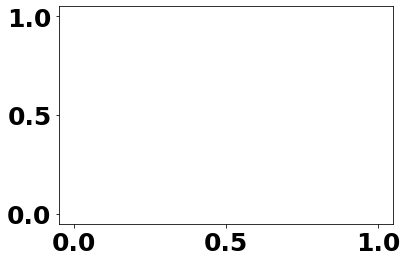

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
# CUDA1?
#data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

##### Make category comparisons

In [13]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [14]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [15]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [16]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [17]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [18]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [19]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [20]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [21]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True, "type": "good-good",
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False, "type": "bad-bad",
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [22]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [23]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None, "type": "good-bad",
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None, "type": "bad-good",
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [24]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=num_pairs_per_class)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [25]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:41, 160132.13it/s]


#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [26]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:01, 99965.02it/s] 
100%|██████████| 192127/192127 [00:00<00:00, 470447.57it/s]


#### Load category tree

- hierarchy of categories

In [27]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [28]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

---

#### dataframe for training etc.

In [33]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

df = filter_min_review_freq(df, min_ratings=8)
df = filter_both_good_bad(df)

df_traindev = make_or_load_pairs(df, str(fn_yelp_df), num_pairs_per_class=4)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

---

#### Reloading for training

_(unused)_

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

---
---
---

## Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
! pip install --upgrade mxnet-cu102
! pip install --upgrade gluonnlp 

In [ ]:
! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [29]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X, names_columns_X_arteval, names_columns_y
# names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'type']
names_columns_X = names_columns_X + ['type']

from sklearn.model_selection import train_test_split

In [30]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [31]:
# extracted to include "type" (of pairing)
# train dev set - 70% 30%
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[names_columns_X]
    y = df[names_columns_y]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

---

In [ ]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_1_pro128BCE

In [ ]:
run_name = "yelp_3_arts_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "Arts & Entertainment"

! mkdir data/yelp_3_arts_pro128BCE

In [ ]:
run_name = "yelp_7_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_7_pro128BCE

In [32]:
run_name = "yelp_8_pro512BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_8_pro512BCE

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)
    
len(traindev_df)  # pairs

In [ ]:
#epoch_id = num_epochs - 1
#fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
#print(f"Load {fn_model_state} ...")
#model.load_parameters(str(fn_model_state), ctx=ctx)

---

In [34]:
len(traindev_df)  # pairs

703760

In [35]:
# check how many pairs are per pairing
for pairtype, df_grouped in traindev_df.groupby(["type"]):
    print(pairtype, len(df_grouped))
    # df_grouped.describe()

bad-bad 175940
bad-good 175940
good-bad 175940
good-good 175940


---

In [36]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
traindev_df["tag"] = "NA"

In [37]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [38]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro512bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:02.714479


In [39]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:53.941476


In [40]:
num_epochs = 3
batch_size = 6

  0%|          | 160/633384 [00:00<06:36, 1598.76it/s]

Start on [train model (eval per epoch)] ...
Start on [train model - 0] ...
Start on [setup training] ...


  0%|          | 0/105568 [00:00<?, ?it/s]

Time for [setup training]: 0:06:24.312008
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/105568 [00:00<23:21:24,  1.26it/s]2020-06-14 18:21:50,620 : INFO : successfully opened events file: data/yelp_8_pro512BCE/events.out.tfevents.1592151710.cuda2
2020-06-14 18:21:50,625 : INFO : wrote 1 event to disk
2020-06-14 18:21:50,626 : INFO : wrote 1 event to disk
  0%|          | 500/105568 [01:44<6:07:26,  4.77it/s]

[Epoch 0 Batch 500/105568] loss=0.6047, lr=0.0000050, acc=0.664 - time 0:01:44.982480


  1%|          | 1000/105568 [03:30<6:09:34,  4.72it/s]

[Epoch 0 Batch 1000/105568] loss=0.4915, lr=0.0000050, acc=0.720 - time 0:01:45.551998


  1%|▏         | 1500/105568 [05:16<6:03:21,  4.77it/s]

[Epoch 0 Batch 1500/105568] loss=0.4777, lr=0.0000050, acc=0.742 - time 0:01:45.756207


  2%|▏         | 2000/105568 [07:02<6:06:04,  4.72it/s]

[Epoch 0 Batch 2000/105568] loss=0.4405, lr=0.0000050, acc=0.757 - time 0:01:46.004705


  2%|▏         | 2500/105568 [08:48<6:07:29,  4.67it/s]

[Epoch 0 Batch 2500/105568] loss=0.4469, lr=0.0000050, acc=0.766 - time 0:01:45.884053


  3%|▎         | 3000/105568 [10:33<5:59:47,  4.75it/s]

[Epoch 0 Batch 3000/105568] loss=0.4318, lr=0.0000050, acc=0.775 - time 0:01:45.794376


  3%|▎         | 3500/105568 [12:19<6:01:19,  4.71it/s]

[Epoch 0 Batch 3500/105568] loss=0.4394, lr=0.0000050, acc=0.782 - time 0:01:45.784449


  4%|▍         | 4000/105568 [14:05<5:56:57,  4.74it/s]

[Epoch 0 Batch 4000/105568] loss=0.4191, lr=0.0000050, acc=0.786 - time 0:01:45.789562


  4%|▍         | 4500/105568 [15:51<5:57:58,  4.71it/s]

[Epoch 0 Batch 4500/105568] loss=0.4121, lr=0.0000050, acc=0.790 - time 0:01:45.951103


  5%|▍         | 5000/105568 [17:37<5:53:55,  4.74it/s]

[Epoch 0 Batch 5000/105568] loss=0.4302, lr=0.0000050, acc=0.793 - time 0:01:45.853207


  5%|▌         | 5500/105568 [19:23<5:51:34,  4.74it/s]

[Epoch 0 Batch 5500/105568] loss=0.4026, lr=0.0000050, acc=0.797 - time 0:01:45.868765


  6%|▌         | 6000/105568 [21:09<5:52:23,  4.71it/s]

[Epoch 0 Batch 6000/105568] loss=0.4271, lr=0.0000050, acc=0.799 - time 0:01:45.899364


  6%|▌         | 6500/105568 [22:54<5:48:39,  4.74it/s]

[Epoch 0 Batch 6500/105568] loss=0.3926, lr=0.0000050, acc=0.802 - time 0:01:45.857359


  7%|▋         | 7000/105568 [24:41<5:48:03,  4.72it/s]

[Epoch 0 Batch 7000/105568] loss=0.4003, lr=0.0000050, acc=0.805 - time 0:01:46.516048


  7%|▋         | 7500/105568 [26:27<5:47:22,  4.71it/s]

[Epoch 0 Batch 7500/105568] loss=0.4167, lr=0.0000050, acc=0.807 - time 0:01:45.873335


  8%|▊         | 8000/105568 [28:13<5:42:40,  4.75it/s]

[Epoch 0 Batch 8000/105568] loss=0.4184, lr=0.0000050, acc=0.807 - time 0:01:45.808976


  8%|▊         | 8500/105568 [29:59<5:41:38,  4.74it/s]

[Epoch 0 Batch 8500/105568] loss=0.4079, lr=0.0000050, acc=0.808 - time 0:01:45.826878


  9%|▊         | 9000/105568 [31:44<5:45:53,  4.65it/s]

[Epoch 0 Batch 9000/105568] loss=0.4087, lr=0.0000050, acc=0.809 - time 0:01:45.774376


  9%|▉         | 9500/105568 [33:30<5:34:46,  4.78it/s]

[Epoch 0 Batch 9500/105568] loss=0.3850, lr=0.0000050, acc=0.811 - time 0:01:45.789078


  9%|▉         | 10000/105568 [35:16<5:32:23,  4.79it/s]

[Epoch 0 Batch 10000/105568] loss=0.4031, lr=0.0000050, acc=0.812 - time 0:01:45.781216


 10%|▉         | 10500/105568 [37:02<5:33:13,  4.76it/s]

[Epoch 0 Batch 10500/105568] loss=0.3988, lr=0.0000050, acc=0.813 - time 0:01:45.923164


 10%|█         | 11000/105568 [38:47<5:29:34,  4.78it/s]

[Epoch 0 Batch 11000/105568] loss=0.3910, lr=0.0000050, acc=0.815 - time 0:01:45.610398


 11%|█         | 11500/105568 [40:33<5:31:35,  4.73it/s]

[Epoch 0 Batch 11500/105568] loss=0.4066, lr=0.0000050, acc=0.816 - time 0:01:45.762590


 11%|█▏        | 12000/105568 [42:19<5:30:50,  4.71it/s]

[Epoch 0 Batch 12000/105568] loss=0.4035, lr=0.0000050, acc=0.817 - time 0:01:45.835676


 12%|█▏        | 12500/105568 [44:05<5:30:16,  4.70it/s]

[Epoch 0 Batch 12500/105568] loss=0.4046, lr=0.0000050, acc=0.818 - time 0:01:45.800854


 12%|█▏        | 13000/105568 [45:51<5:28:22,  4.70it/s]

[Epoch 0 Batch 13000/105568] loss=0.4020, lr=0.0000050, acc=0.818 - time 0:01:45.835103


 13%|█▎        | 13500/105568 [47:37<5:19:49,  4.80it/s]

[Epoch 0 Batch 13500/105568] loss=0.3822, lr=0.0000050, acc=0.819 - time 0:01:46.266712


 13%|█▎        | 14000/105568 [49:23<5:22:06,  4.74it/s]

[Epoch 0 Batch 14000/105568] loss=0.4166, lr=0.0000050, acc=0.820 - time 0:01:45.934263


 14%|█▎        | 14500/105568 [51:09<5:22:26,  4.71it/s]

[Epoch 0 Batch 14500/105568] loss=0.4073, lr=0.0000050, acc=0.821 - time 0:01:45.813461


 14%|█▍        | 15000/105568 [52:54<5:17:38,  4.75it/s]

[Epoch 0 Batch 15000/105568] loss=0.4001, lr=0.0000050, acc=0.821 - time 0:01:45.806244


 15%|█▍        | 15500/105568 [54:40<5:16:09,  4.75it/s]

[Epoch 0 Batch 15500/105568] loss=0.4025, lr=0.0000050, acc=0.822 - time 0:01:45.693597


 15%|█▌        | 16000/105568 [56:26<5:13:47,  4.76it/s]

[Epoch 0 Batch 16000/105568] loss=0.3995, lr=0.0000050, acc=0.823 - time 0:01:45.796632


 16%|█▌        | 16500/105568 [58:12<5:13:04,  4.74it/s]

[Epoch 0 Batch 16500/105568] loss=0.4202, lr=0.0000050, acc=0.823 - time 0:01:45.826335


 16%|█▌        | 17000/105568 [59:57<5:14:34,  4.69it/s]

[Epoch 0 Batch 17000/105568] loss=0.3836, lr=0.0000050, acc=0.823 - time 0:01:45.641854


 17%|█▋        | 17500/105568 [1:01:43<5:07:23,  4.78it/s]

[Epoch 0 Batch 17500/105568] loss=0.3831, lr=0.0000050, acc=0.824 - time 0:01:45.962006


 17%|█▋        | 18000/105568 [1:03:29<5:05:41,  4.77it/s]

[Epoch 0 Batch 18000/105568] loss=0.3790, lr=0.0000050, acc=0.825 - time 0:01:45.924609


 18%|█▊        | 18500/105568 [1:05:15<5:08:20,  4.71it/s]

[Epoch 0 Batch 18500/105568] loss=0.3977, lr=0.0000050, acc=0.825 - time 0:01:45.848798


 18%|█▊        | 19000/105568 [1:07:01<5:07:03,  4.70it/s]

[Epoch 0 Batch 19000/105568] loss=0.3955, lr=0.0000050, acc=0.826 - time 0:01:45.918949


 18%|█▊        | 19500/105568 [1:08:47<5:03:17,  4.73it/s]

[Epoch 0 Batch 19500/105568] loss=0.3990, lr=0.0000050, acc=0.826 - time 0:01:45.709584


 19%|█▉        | 20000/105568 [1:10:33<5:01:59,  4.72it/s]

[Epoch 0 Batch 20000/105568] loss=0.3898, lr=0.0000050, acc=0.827 - time 0:01:46.140158


 19%|█▉        | 20500/105568 [1:12:19<4:58:38,  4.75it/s]

[Epoch 0 Batch 20500/105568] loss=0.3829, lr=0.0000050, acc=0.827 - time 0:01:45.887054


 20%|█▉        | 21000/105568 [1:14:05<4:57:46,  4.73it/s]

[Epoch 0 Batch 21000/105568] loss=0.3985, lr=0.0000050, acc=0.828 - time 0:01:45.807953


 20%|██        | 21500/105568 [1:15:50<4:59:26,  4.68it/s]

[Epoch 0 Batch 21500/105568] loss=0.3873, lr=0.0000050, acc=0.828 - time 0:01:45.690050


 21%|██        | 22000/105568 [1:17:36<4:51:00,  4.79it/s]

[Epoch 0 Batch 22000/105568] loss=0.3821, lr=0.0000050, acc=0.829 - time 0:01:45.949371


 21%|██▏       | 22500/105568 [1:19:22<4:55:03,  4.69it/s]

[Epoch 0 Batch 22500/105568] loss=0.4052, lr=0.0000050, acc=0.829 - time 0:01:45.743674


 22%|██▏       | 23000/105568 [1:21:08<4:51:07,  4.73it/s]

[Epoch 0 Batch 23000/105568] loss=0.3961, lr=0.0000050, acc=0.830 - time 0:01:45.877523


 22%|██▏       | 23500/105568 [1:22:54<4:48:24,  4.74it/s]

[Epoch 0 Batch 23500/105568] loss=0.3900, lr=0.0000050, acc=0.830 - time 0:01:45.834308


 23%|██▎       | 24000/105568 [1:24:39<4:44:43,  4.77it/s]

[Epoch 0 Batch 24000/105568] loss=0.3807, lr=0.0000050, acc=0.831 - time 0:01:45.760399


 23%|██▎       | 24500/105568 [1:26:25<4:47:29,  4.70it/s]

[Epoch 0 Batch 24500/105568] loss=0.3816, lr=0.0000050, acc=0.831 - time 0:01:46.005559


 24%|██▎       | 25000/105568 [1:28:11<4:45:34,  4.70it/s]

[Epoch 0 Batch 25000/105568] loss=0.3911, lr=0.0000050, acc=0.831 - time 0:01:45.861513


 24%|██▍       | 25500/105568 [1:29:57<4:42:37,  4.72it/s]

[Epoch 0 Batch 25500/105568] loss=0.3747, lr=0.0000050, acc=0.832 - time 0:01:45.841014


 25%|██▍       | 26000/105568 [1:31:43<4:39:13,  4.75it/s]

[Epoch 0 Batch 26000/105568] loss=0.3625, lr=0.0000050, acc=0.833 - time 0:01:45.752300


 25%|██▌       | 26500/105568 [1:33:29<4:39:09,  4.72it/s]

[Epoch 0 Batch 26500/105568] loss=0.3798, lr=0.0000050, acc=0.833 - time 0:01:45.754971


 26%|██▌       | 27000/105568 [1:35:14<4:35:27,  4.75it/s]

[Epoch 0 Batch 27000/105568] loss=0.3638, lr=0.0000050, acc=0.834 - time 0:01:45.756003


 26%|██▌       | 27500/105568 [1:37:00<4:41:28,  4.62it/s]

[Epoch 0 Batch 27500/105568] loss=0.3924, lr=0.0000050, acc=0.834 - time 0:01:45.705334


 27%|██▋       | 28000/105568 [1:38:46<4:31:03,  4.77it/s]

[Epoch 0 Batch 28000/105568] loss=0.3786, lr=0.0000050, acc=0.834 - time 0:01:45.794405


 27%|██▋       | 28500/105568 [1:40:32<4:29:39,  4.76it/s]

[Epoch 0 Batch 28500/105568] loss=0.3898, lr=0.0000050, acc=0.835 - time 0:01:45.782526


 27%|██▋       | 29000/105568 [1:42:17<4:30:06,  4.72it/s]

[Epoch 0 Batch 29000/105568] loss=0.3947, lr=0.0000050, acc=0.835 - time 0:01:45.708109


 28%|██▊       | 29500/105568 [1:44:03<4:27:38,  4.74it/s]

[Epoch 0 Batch 29500/105568] loss=0.3747, lr=0.0000050, acc=0.835 - time 0:01:45.498279


 28%|██▊       | 30000/105568 [1:45:49<4:28:47,  4.69it/s]

[Epoch 0 Batch 30000/105568] loss=0.3887, lr=0.0000050, acc=0.835 - time 0:01:45.706465


 29%|██▉       | 30500/105568 [1:47:34<4:25:45,  4.71it/s]

[Epoch 0 Batch 30500/105568] loss=0.3769, lr=0.0000050, acc=0.836 - time 0:01:45.567394


 29%|██▉       | 31000/105568 [1:49:20<4:19:55,  4.78it/s]

[Epoch 0 Batch 31000/105568] loss=0.3900, lr=0.0000050, acc=0.836 - time 0:01:45.738900


 30%|██▉       | 31500/105568 [1:51:06<4:21:31,  4.72it/s]

[Epoch 0 Batch 31500/105568] loss=0.3951, lr=0.0000050, acc=0.836 - time 0:01:46.086244


 30%|███       | 32000/105568 [1:52:52<4:19:52,  4.72it/s]

[Epoch 0 Batch 32000/105568] loss=0.3910, lr=0.0000050, acc=0.836 - time 0:01:45.890945


 31%|███       | 32500/105568 [1:54:38<4:22:49,  4.63it/s]

[Epoch 0 Batch 32500/105568] loss=0.3888, lr=0.0000050, acc=0.837 - time 0:01:45.694147


 31%|███▏      | 33000/105568 [1:56:23<4:15:45,  4.73it/s]

[Epoch 0 Batch 33000/105568] loss=0.3890, lr=0.0000050, acc=0.837 - time 0:01:45.716207


 32%|███▏      | 33500/105568 [1:58:09<4:17:26,  4.67it/s]

[Epoch 0 Batch 33500/105568] loss=0.3816, lr=0.0000050, acc=0.837 - time 0:01:45.639468


 32%|███▏      | 34000/105568 [1:59:55<4:18:27,  4.62it/s]

[Epoch 0 Batch 34000/105568] loss=0.3671, lr=0.0000050, acc=0.837 - time 0:01:45.756962


 33%|███▎      | 34500/105568 [2:01:40<4:09:58,  4.74it/s]

[Epoch 0 Batch 34500/105568] loss=0.3806, lr=0.0000050, acc=0.837 - time 0:01:45.511633


 33%|███▎      | 35000/105568 [2:03:26<4:07:22,  4.75it/s]

[Epoch 0 Batch 35000/105568] loss=0.3790, lr=0.0000050, acc=0.838 - time 0:01:45.678525


 34%|███▎      | 35500/105568 [2:05:11<4:08:00,  4.71it/s]

[Epoch 0 Batch 35500/105568] loss=0.3789, lr=0.0000050, acc=0.838 - time 0:01:45.467279


 34%|███▍      | 36000/105568 [2:06:57<4:06:18,  4.71it/s]

[Epoch 0 Batch 36000/105568] loss=0.3824, lr=0.0000050, acc=0.838 - time 0:01:45.758837


 35%|███▍      | 36500/105568 [2:08:43<4:02:05,  4.75it/s]

[Epoch 0 Batch 36500/105568] loss=0.3648, lr=0.0000050, acc=0.838 - time 0:01:45.833531


 35%|███▌      | 37000/105568 [2:10:29<4:01:33,  4.73it/s]

[Epoch 0 Batch 37000/105568] loss=0.3759, lr=0.0000050, acc=0.839 - time 0:01:45.608107


 36%|███▌      | 37500/105568 [2:12:14<3:58:01,  4.77it/s]

[Epoch 0 Batch 37500/105568] loss=0.3735, lr=0.0000050, acc=0.839 - time 0:01:45.593715


 36%|███▌      | 38000/105568 [2:14:00<3:56:38,  4.76it/s]

[Epoch 0 Batch 38000/105568] loss=0.3723, lr=0.0000050, acc=0.839 - time 0:01:45.637491


 36%|███▋      | 38500/105568 [2:15:45<3:55:29,  4.75it/s]

[Epoch 0 Batch 38500/105568] loss=0.3877, lr=0.0000050, acc=0.839 - time 0:01:45.386353


 37%|███▋      | 39000/105568 [2:17:31<3:50:48,  4.81it/s]

[Epoch 0 Batch 39000/105568] loss=0.3846, lr=0.0000050, acc=0.840 - time 0:01:45.692020


 37%|███▋      | 39500/105568 [2:19:17<3:54:57,  4.69it/s]

[Epoch 0 Batch 39500/105568] loss=0.3792, lr=0.0000050, acc=0.840 - time 0:01:46.252234


 38%|███▊      | 40000/105568 [2:21:03<3:52:33,  4.70it/s]

[Epoch 0 Batch 40000/105568] loss=0.3868, lr=0.0000050, acc=0.840 - time 0:01:45.727284


 38%|███▊      | 40500/105568 [2:22:48<3:49:18,  4.73it/s]

[Epoch 0 Batch 40500/105568] loss=0.4026, lr=0.0000050, acc=0.840 - time 0:01:45.503418


 39%|███▉      | 41000/105568 [2:24:34<3:46:52,  4.74it/s]

[Epoch 0 Batch 41000/105568] loss=0.3910, lr=0.0000050, acc=0.841 - time 0:01:45.478842


 39%|███▉      | 41500/105568 [2:26:19<3:47:32,  4.69it/s]

[Epoch 0 Batch 41500/105568] loss=0.3899, lr=0.0000050, acc=0.841 - time 0:01:45.518107


 40%|███▉      | 42000/105568 [2:28:05<3:42:39,  4.76it/s]

[Epoch 0 Batch 42000/105568] loss=0.3818, lr=0.0000050, acc=0.841 - time 0:01:45.432265


 40%|████      | 42500/105568 [2:29:50<3:46:20,  4.64it/s]

[Epoch 0 Batch 42500/105568] loss=0.3757, lr=0.0000050, acc=0.841 - time 0:01:45.465801


 41%|████      | 43000/105568 [2:31:36<3:39:19,  4.75it/s]

[Epoch 0 Batch 43000/105568] loss=0.3907, lr=0.0000050, acc=0.842 - time 0:01:45.574355


 41%|████      | 43500/105568 [2:33:22<3:39:23,  4.72it/s]

[Epoch 0 Batch 43500/105568] loss=0.3848, lr=0.0000050, acc=0.842 - time 0:01:45.689384


 42%|████▏     | 44000/105568 [2:35:07<3:36:47,  4.73it/s]

[Epoch 0 Batch 44000/105568] loss=0.3578, lr=0.0000050, acc=0.842 - time 0:01:45.608030


 42%|████▏     | 44500/105568 [2:36:53<3:33:15,  4.77it/s]

[Epoch 0 Batch 44500/105568] loss=0.3738, lr=0.0000050, acc=0.842 - time 0:01:45.459470


 43%|████▎     | 45000/105568 [2:38:38<3:34:00,  4.72it/s]

[Epoch 0 Batch 45000/105568] loss=0.3951, lr=0.0000050, acc=0.843 - time 0:01:45.709759


 43%|████▎     | 45500/105568 [2:40:24<3:31:17,  4.74it/s]

[Epoch 0 Batch 45500/105568] loss=0.3954, lr=0.0000050, acc=0.843 - time 0:01:45.684770


 44%|████▎     | 46000/105568 [2:42:10<3:31:04,  4.70it/s]

[Epoch 0 Batch 46000/105568] loss=0.3980, lr=0.0000050, acc=0.843 - time 0:01:45.698668


 44%|████▍     | 46500/105568 [2:43:56<3:29:04,  4.71it/s]

[Epoch 0 Batch 46500/105568] loss=0.3710, lr=0.0000050, acc=0.843 - time 0:01:46.027930


 45%|████▍     | 47000/105568 [2:45:41<3:24:57,  4.76it/s]

[Epoch 0 Batch 47000/105568] loss=0.4034, lr=0.0000050, acc=0.843 - time 0:01:45.572713


 45%|████▍     | 47500/105568 [2:47:27<3:25:07,  4.72it/s]

[Epoch 0 Batch 47500/105568] loss=0.3742, lr=0.0000050, acc=0.843 - time 0:01:45.666530


 45%|████▌     | 48000/105568 [2:49:13<3:22:54,  4.73it/s]

[Epoch 0 Batch 48000/105568] loss=0.3898, lr=0.0000050, acc=0.843 - time 0:01:45.766062


 46%|████▌     | 48500/105568 [2:50:58<3:22:09,  4.71it/s]

[Epoch 0 Batch 48500/105568] loss=0.3798, lr=0.0000050, acc=0.843 - time 0:01:45.512482


 46%|████▋     | 49000/105568 [2:52:44<3:17:37,  4.77it/s]

[Epoch 0 Batch 49000/105568] loss=0.3922, lr=0.0000050, acc=0.844 - time 0:01:45.507002


 47%|████▋     | 49500/105568 [2:54:29<3:24:11,  4.58it/s]

[Epoch 0 Batch 49500/105568] loss=0.3721, lr=0.0000050, acc=0.844 - time 0:01:45.683652


 47%|████▋     | 50000/105568 [2:56:15<3:14:17,  4.77it/s]

[Epoch 0 Batch 50000/105568] loss=0.3646, lr=0.0000050, acc=0.844 - time 0:01:45.686929


 48%|████▊     | 50500/105568 [2:58:01<3:13:45,  4.74it/s]

[Epoch 0 Batch 50500/105568] loss=0.3788, lr=0.0000050, acc=0.844 - time 0:01:45.663621


 48%|████▊     | 51000/105568 [2:59:46<3:12:40,  4.72it/s]

[Epoch 0 Batch 51000/105568] loss=0.3817, lr=0.0000050, acc=0.844 - time 0:01:45.615639


 49%|████▉     | 51500/105568 [3:01:32<3:11:21,  4.71it/s]

[Epoch 0 Batch 51500/105568] loss=0.3835, lr=0.0000050, acc=0.844 - time 0:01:45.667900


 49%|████▉     | 52000/105568 [3:03:18<3:08:12,  4.74it/s]

[Epoch 0 Batch 52000/105568] loss=0.3690, lr=0.0000050, acc=0.845 - time 0:01:45.508249


 50%|████▉     | 52500/105568 [3:05:03<3:06:44,  4.74it/s]

[Epoch 0 Batch 52500/105568] loss=0.3581, lr=0.0000050, acc=0.845 - time 0:01:45.625636


 50%|█████     | 53000/105568 [3:06:49<3:05:09,  4.73it/s]

[Epoch 0 Batch 53000/105568] loss=0.3661, lr=0.0000050, acc=0.845 - time 0:01:45.998837


 51%|█████     | 53500/105568 [3:08:35<3:04:06,  4.71it/s]

[Epoch 0 Batch 53500/105568] loss=0.3866, lr=0.0000050, acc=0.845 - time 0:01:45.497940


 51%|█████     | 54000/105568 [3:10:20<3:01:36,  4.73it/s]

[Epoch 0 Batch 54000/105568] loss=0.3648, lr=0.0000050, acc=0.845 - time 0:01:45.639253


 52%|█████▏    | 54500/105568 [3:12:06<2:59:48,  4.73it/s]

[Epoch 0 Batch 54500/105568] loss=0.3793, lr=0.0000050, acc=0.846 - time 0:01:45.663104


 52%|█████▏    | 55000/105568 [3:13:52<2:57:18,  4.75it/s]

[Epoch 0 Batch 55000/105568] loss=0.3938, lr=0.0000050, acc=0.846 - time 0:01:45.668575


 53%|█████▎    | 55500/105568 [3:15:37<2:55:25,  4.76it/s]

[Epoch 0 Batch 55500/105568] loss=0.3907, lr=0.0000050, acc=0.846 - time 0:01:45.732164


 53%|█████▎    | 56000/105568 [3:17:23<2:53:09,  4.77it/s]

[Epoch 0 Batch 56000/105568] loss=0.3990, lr=0.0000050, acc=0.846 - time 0:01:45.569276


 54%|█████▎    | 56500/105568 [3:19:09<2:55:11,  4.67it/s]

[Epoch 0 Batch 56500/105568] loss=0.3628, lr=0.0000050, acc=0.846 - time 0:01:45.777073


 54%|█████▍    | 57000/105568 [3:20:54<2:50:29,  4.75it/s]

[Epoch 0 Batch 57000/105568] loss=0.3805, lr=0.0000050, acc=0.846 - time 0:01:45.708411


 54%|█████▍    | 57500/105568 [3:22:40<2:48:46,  4.75it/s]

[Epoch 0 Batch 57500/105568] loss=0.3716, lr=0.0000050, acc=0.846 - time 0:01:45.545266


 55%|█████▍    | 58000/105568 [3:24:26<2:46:25,  4.76it/s]

[Epoch 0 Batch 58000/105568] loss=0.4096, lr=0.0000050, acc=0.846 - time 0:01:45.611473


 55%|█████▌    | 58500/105568 [3:26:11<2:46:11,  4.72it/s]

[Epoch 0 Batch 58500/105568] loss=0.3756, lr=0.0000050, acc=0.846 - time 0:01:45.698943


 56%|█████▌    | 59000/105568 [3:27:57<2:44:27,  4.72it/s]

[Epoch 0 Batch 59000/105568] loss=0.3642, lr=0.0000050, acc=0.847 - time 0:01:46.124475


 56%|█████▋    | 59500/105568 [3:29:43<2:42:58,  4.71it/s]

[Epoch 0 Batch 59500/105568] loss=0.3861, lr=0.0000050, acc=0.847 - time 0:01:45.601992


 57%|█████▋    | 60000/105568 [3:31:29<2:41:17,  4.71it/s]

[Epoch 0 Batch 60000/105568] loss=0.3765, lr=0.0000050, acc=0.847 - time 0:01:45.754394


 57%|█████▋    | 60500/105568 [3:33:14<2:40:04,  4.69it/s]

[Epoch 0 Batch 60500/105568] loss=0.3884, lr=0.0000050, acc=0.847 - time 0:01:45.588483


 58%|█████▊    | 61000/105568 [3:35:00<2:36:17,  4.75it/s]

[Epoch 0 Batch 61000/105568] loss=0.3466, lr=0.0000050, acc=0.847 - time 0:01:45.543153


 58%|█████▊    | 61500/105568 [3:36:46<2:35:56,  4.71it/s]

[Epoch 0 Batch 61500/105568] loss=0.3840, lr=0.0000050, acc=0.847 - time 0:01:45.741095


 59%|█████▊    | 62000/105568 [3:38:31<2:32:59,  4.75it/s]

[Epoch 0 Batch 62000/105568] loss=0.3623, lr=0.0000050, acc=0.847 - time 0:01:45.680938


 59%|█████▉    | 62500/105568 [3:40:17<2:32:43,  4.70it/s]

[Epoch 0 Batch 62500/105568] loss=0.3844, lr=0.0000050, acc=0.848 - time 0:01:45.639178


 60%|█████▉    | 63000/105568 [3:42:03<2:30:48,  4.70it/s]

[Epoch 0 Batch 63000/105568] loss=0.3615, lr=0.0000050, acc=0.848 - time 0:01:45.771195


 60%|██████    | 63500/105568 [3:43:48<2:27:33,  4.75it/s]

[Epoch 0 Batch 63500/105568] loss=0.3755, lr=0.0000050, acc=0.848 - time 0:01:45.731409


 61%|██████    | 64000/105568 [3:45:34<2:25:52,  4.75it/s]

[Epoch 0 Batch 64000/105568] loss=0.3697, lr=0.0000050, acc=0.848 - time 0:01:45.486197


 61%|██████    | 64500/105568 [3:47:20<2:26:53,  4.66it/s]

[Epoch 0 Batch 64500/105568] loss=0.3671, lr=0.0000050, acc=0.848 - time 0:01:46.158198


 62%|██████▏   | 65000/105568 [3:49:06<2:24:28,  4.68it/s]

[Epoch 0 Batch 65000/105568] loss=0.3757, lr=0.0000050, acc=0.848 - time 0:01:45.515019


 62%|██████▏   | 65500/105568 [3:50:51<2:20:40,  4.75it/s]

[Epoch 0 Batch 65500/105568] loss=0.3724, lr=0.0000050, acc=0.848 - time 0:01:45.437182


 63%|██████▎   | 66000/105568 [3:52:37<2:17:55,  4.78it/s]

[Epoch 0 Batch 66000/105568] loss=0.3816, lr=0.0000050, acc=0.848 - time 0:01:45.686240


 63%|██████▎   | 66500/105568 [3:54:22<2:16:12,  4.78it/s]

[Epoch 0 Batch 66500/105568] loss=0.3754, lr=0.0000050, acc=0.848 - time 0:01:45.634211


 63%|██████▎   | 67000/105568 [3:56:08<2:15:53,  4.73it/s]

[Epoch 0 Batch 67000/105568] loss=0.3717, lr=0.0000050, acc=0.849 - time 0:01:45.380557


 64%|██████▍   | 67500/105568 [3:57:53<2:14:17,  4.72it/s]

[Epoch 0 Batch 67500/105568] loss=0.3673, lr=0.0000050, acc=0.849 - time 0:01:45.583772


 64%|██████▍   | 68000/105568 [3:59:39<2:11:58,  4.74it/s]

[Epoch 0 Batch 68000/105568] loss=0.3970, lr=0.0000050, acc=0.849 - time 0:01:45.596333


 65%|██████▍   | 68500/105568 [4:01:25<2:11:48,  4.69it/s]

[Epoch 0 Batch 68500/105568] loss=0.3827, lr=0.0000050, acc=0.849 - time 0:01:45.734020


 65%|██████▌   | 69000/105568 [4:03:10<2:06:47,  4.81it/s]

[Epoch 0 Batch 69000/105568] loss=0.3804, lr=0.0000050, acc=0.849 - time 0:01:45.451772


 66%|██████▌   | 69500/105568 [4:04:56<2:07:49,  4.70it/s]

[Epoch 0 Batch 69500/105568] loss=0.3600, lr=0.0000050, acc=0.849 - time 0:01:45.484650


 66%|██████▋   | 70000/105568 [4:06:41<2:04:13,  4.77it/s]

[Epoch 0 Batch 70000/105568] loss=0.3837, lr=0.0000050, acc=0.849 - time 0:01:45.647783


 67%|██████▋   | 70500/105568 [4:08:27<2:03:14,  4.74it/s]

[Epoch 0 Batch 70500/105568] loss=0.3898, lr=0.0000050, acc=0.849 - time 0:01:45.999754


 67%|██████▋   | 71000/105568 [4:10:13<2:01:03,  4.76it/s]

[Epoch 0 Batch 71000/105568] loss=0.3734, lr=0.0000050, acc=0.849 - time 0:01:45.564027


 68%|██████▊   | 71500/105568 [4:11:58<2:00:57,  4.69it/s]

[Epoch 0 Batch 71500/105568] loss=0.3669, lr=0.0000050, acc=0.849 - time 0:01:45.541860


 68%|██████▊   | 72000/105568 [4:13:44<1:57:50,  4.75it/s]

[Epoch 0 Batch 72000/105568] loss=0.3878, lr=0.0000050, acc=0.850 - time 0:01:45.425929


 69%|██████▊   | 72500/105568 [4:15:29<1:55:04,  4.79it/s]

[Epoch 0 Batch 72500/105568] loss=0.3775, lr=0.0000050, acc=0.850 - time 0:01:45.518898


 69%|██████▉   | 73000/105568 [4:17:15<1:53:50,  4.77it/s]

[Epoch 0 Batch 73000/105568] loss=0.3749, lr=0.0000050, acc=0.850 - time 0:01:45.555358


 70%|██████▉   | 73500/105568 [4:19:00<1:53:45,  4.70it/s]

[Epoch 0 Batch 73500/105568] loss=0.3692, lr=0.0000050, acc=0.850 - time 0:01:45.511361


 70%|███████   | 74000/105568 [4:20:46<1:50:24,  4.77it/s]

[Epoch 0 Batch 74000/105568] loss=0.3713, lr=0.0000050, acc=0.850 - time 0:01:45.637396


 71%|███████   | 74500/105568 [4:22:31<1:50:05,  4.70it/s]

[Epoch 0 Batch 74500/105568] loss=0.3797, lr=0.0000050, acc=0.850 - time 0:01:45.407092


 71%|███████   | 75000/105568 [4:24:17<1:47:28,  4.74it/s]

[Epoch 0 Batch 75000/105568] loss=0.3554, lr=0.0000050, acc=0.850 - time 0:01:45.878706


 72%|███████▏  | 75500/105568 [4:26:03<1:45:28,  4.75it/s]

[Epoch 0 Batch 75500/105568] loss=0.3644, lr=0.0000050, acc=0.850 - time 0:01:45.744359


 72%|███████▏  | 76000/105568 [4:27:49<1:42:58,  4.79it/s]

[Epoch 0 Batch 76000/105568] loss=0.3677, lr=0.0000050, acc=0.850 - time 0:01:45.584126


 72%|███████▏  | 76500/105568 [4:29:34<1:41:37,  4.77it/s]

[Epoch 0 Batch 76500/105568] loss=0.3711, lr=0.0000050, acc=0.850 - time 0:01:45.597376


 73%|███████▎  | 77000/105568 [4:31:20<1:40:02,  4.76it/s]

[Epoch 0 Batch 77000/105568] loss=0.3800, lr=0.0000050, acc=0.850 - time 0:01:45.875365


 73%|███████▎  | 77500/105568 [4:33:06<1:37:44,  4.79it/s]

[Epoch 0 Batch 77500/105568] loss=0.4033, lr=0.0000050, acc=0.850 - time 0:01:45.688588


 74%|███████▍  | 78000/105568 [4:34:51<1:37:29,  4.71it/s]

[Epoch 0 Batch 78000/105568] loss=0.3793, lr=0.0000050, acc=0.850 - time 0:01:45.636019


 74%|███████▍  | 78500/105568 [4:36:37<1:34:05,  4.79it/s]

[Epoch 0 Batch 78500/105568] loss=0.3732, lr=0.0000050, acc=0.851 - time 0:01:45.800203


 75%|███████▍  | 79000/105568 [4:38:23<1:32:43,  4.78it/s]

[Epoch 0 Batch 79000/105568] loss=0.3586, lr=0.0000050, acc=0.851 - time 0:01:45.547075


 75%|███████▌  | 79500/105568 [4:40:09<1:31:58,  4.72it/s]

[Epoch 0 Batch 79500/105568] loss=0.3906, lr=0.0000050, acc=0.851 - time 0:01:45.755223


 76%|███████▌  | 80000/105568 [4:41:54<1:31:09,  4.67it/s]

[Epoch 0 Batch 80000/105568] loss=0.3770, lr=0.0000050, acc=0.851 - time 0:01:45.864944


 76%|███████▋  | 80500/105568 [4:43:40<1:28:03,  4.74it/s]

[Epoch 0 Batch 80500/105568] loss=0.3697, lr=0.0000050, acc=0.851 - time 0:01:45.560011


 77%|███████▋  | 81000/105568 [4:45:26<1:26:52,  4.71it/s]

[Epoch 0 Batch 81000/105568] loss=0.3664, lr=0.0000050, acc=0.851 - time 0:01:45.648707


 77%|███████▋  | 81500/105568 [4:47:11<1:25:40,  4.68it/s]

[Epoch 0 Batch 81500/105568] loss=0.3749, lr=0.0000050, acc=0.851 - time 0:01:45.821026


 78%|███████▊  | 82000/105568 [4:48:57<1:22:38,  4.75it/s]

[Epoch 0 Batch 82000/105568] loss=0.3735, lr=0.0000050, acc=0.851 - time 0:01:45.730983


 78%|███████▊  | 82500/105568 [4:50:43<1:20:28,  4.78it/s]

[Epoch 0 Batch 82500/105568] loss=0.3833, lr=0.0000050, acc=0.851 - time 0:01:45.808850


 79%|███████▊  | 83000/105568 [4:52:29<1:20:00,  4.70it/s]

[Epoch 0 Batch 83000/105568] loss=0.3604, lr=0.0000050, acc=0.851 - time 0:01:45.748336


 79%|███████▉  | 83500/105568 [4:54:14<1:17:28,  4.75it/s]

[Epoch 0 Batch 83500/105568] loss=0.3524, lr=0.0000050, acc=0.851 - time 0:01:45.607762


 80%|███████▉  | 84000/105568 [4:56:00<1:15:35,  4.76it/s]

[Epoch 0 Batch 84000/105568] loss=0.3901, lr=0.0000050, acc=0.851 - time 0:01:45.521020


 80%|████████  | 84500/105568 [4:57:46<1:14:17,  4.73it/s]

[Epoch 0 Batch 84500/105568] loss=0.3572, lr=0.0000050, acc=0.851 - time 0:01:45.683084


 81%|████████  | 85000/105568 [4:59:31<1:12:16,  4.74it/s]

[Epoch 0 Batch 85000/105568] loss=0.3720, lr=0.0000050, acc=0.851 - time 0:01:45.761522


 81%|████████  | 85500/105568 [5:01:17<1:11:22,  4.69it/s]

[Epoch 0 Batch 85500/105568] loss=0.3858, lr=0.0000050, acc=0.851 - time 0:01:46.126916


 81%|████████▏ | 86000/105568 [5:03:03<1:08:45,  4.74it/s]

[Epoch 0 Batch 86000/105568] loss=0.3551, lr=0.0000050, acc=0.852 - time 0:01:45.674196


 82%|████████▏ | 86500/105568 [5:04:49<1:07:11,  4.73it/s]

[Epoch 0 Batch 86500/105568] loss=0.3663, lr=0.0000050, acc=0.852 - time 0:01:45.763784


 82%|████████▏ | 87000/105568 [5:06:34<1:05:02,  4.76it/s]

[Epoch 0 Batch 87000/105568] loss=0.3670, lr=0.0000050, acc=0.852 - time 0:01:45.607663


 83%|████████▎ | 87500/105568 [5:08:20<1:03:26,  4.75it/s]

[Epoch 0 Batch 87500/105568] loss=0.3848, lr=0.0000050, acc=0.852 - time 0:01:45.554514


 83%|████████▎ | 88000/105568 [5:10:06<1:01:25,  4.77it/s]

[Epoch 0 Batch 88000/105568] loss=0.3797, lr=0.0000050, acc=0.852 - time 0:01:45.706770


 84%|████████▍ | 88500/105568 [5:11:52<59:33,  4.78it/s]  

[Epoch 0 Batch 88500/105568] loss=0.3765, lr=0.0000050, acc=0.852 - time 0:01:45.846437


 84%|████████▍ | 89000/105568 [5:13:37<58:40,  4.71it/s]  

[Epoch 0 Batch 89000/105568] loss=0.3895, lr=0.0000050, acc=0.852 - time 0:01:45.665752


 85%|████████▍ | 89500/105568 [5:15:23<56:57,  4.70it/s]  

[Epoch 0 Batch 89500/105568] loss=0.3529, lr=0.0000050, acc=0.852 - time 0:01:45.703935


 85%|████████▌ | 90000/105568 [5:17:09<54:45,  4.74it/s]

[Epoch 0 Batch 90000/105568] loss=0.3494, lr=0.0000050, acc=0.852 - time 0:01:45.650667


 86%|████████▌ | 90500/105568 [5:18:54<53:15,  4.72it/s]

[Epoch 0 Batch 90500/105568] loss=0.3731, lr=0.0000050, acc=0.852 - time 0:01:45.707693


 86%|████████▌ | 91000/105568 [5:20:40<51:53,  4.68it/s]

[Epoch 0 Batch 91000/105568] loss=0.3710, lr=0.0000050, acc=0.852 - time 0:01:45.964551


 87%|████████▋ | 91500/105568 [5:22:26<49:55,  4.70it/s]

[Epoch 0 Batch 91500/105568] loss=0.3609, lr=0.0000050, acc=0.852 - time 0:01:45.694678


 87%|████████▋ | 92000/105568 [5:24:12<47:36,  4.75it/s]

[Epoch 0 Batch 92000/105568] loss=0.3753, lr=0.0000050, acc=0.853 - time 0:01:45.870637


 88%|████████▊ | 92500/105568 [5:25:58<46:38,  4.67it/s]

[Epoch 0 Batch 92500/105568] loss=0.3672, lr=0.0000050, acc=0.853 - time 0:01:45.834297


 88%|████████▊ | 93000/105568 [5:27:44<44:32,  4.70it/s]

[Epoch 0 Batch 93000/105568] loss=0.3836, lr=0.0000050, acc=0.853 - time 0:01:45.886876


 89%|████████▊ | 93500/105568 [5:29:29<42:43,  4.71it/s]

[Epoch 0 Batch 93500/105568] loss=0.3672, lr=0.0000050, acc=0.853 - time 0:01:45.794522


 89%|████████▉ | 94000/105568 [5:31:15<40:44,  4.73it/s]

[Epoch 0 Batch 94000/105568] loss=0.3777, lr=0.0000050, acc=0.853 - time 0:01:45.677917


 90%|████████▉ | 94500/105568 [5:33:01<39:14,  4.70it/s]

[Epoch 0 Batch 94500/105568] loss=0.3630, lr=0.0000050, acc=0.853 - time 0:01:46.016830


 90%|████████▉ | 95000/105568 [5:34:47<37:09,  4.74it/s]

[Epoch 0 Batch 95000/105568] loss=0.3631, lr=0.0000050, acc=0.853 - time 0:01:45.831909


 90%|█████████ | 95500/105568 [5:36:33<35:12,  4.77it/s]

[Epoch 0 Batch 95500/105568] loss=0.3542, lr=0.0000050, acc=0.853 - time 0:01:45.808994


 91%|█████████ | 96000/105568 [5:38:18<34:19,  4.65it/s]

[Epoch 0 Batch 96000/105568] loss=0.3551, lr=0.0000050, acc=0.853 - time 0:01:45.736439


 91%|█████████▏| 96500/105568 [5:40:04<31:40,  4.77it/s]

[Epoch 0 Batch 96500/105568] loss=0.3767, lr=0.0000050, acc=0.853 - time 0:01:45.881826


 92%|█████████▏| 97000/105568 [5:41:50<30:01,  4.76it/s]

[Epoch 0 Batch 97000/105568] loss=0.3690, lr=0.0000050, acc=0.853 - time 0:01:45.876101


 92%|█████████▏| 97500/105568 [5:43:36<28:28,  4.72it/s]

[Epoch 0 Batch 97500/105568] loss=0.3833, lr=0.0000050, acc=0.853 - time 0:01:46.028950


 93%|█████████▎| 98000/105568 [5:45:22<26:36,  4.74it/s]

[Epoch 0 Batch 98000/105568] loss=0.3655, lr=0.0000050, acc=0.853 - time 0:01:46.034633


 93%|█████████▎| 98500/105568 [5:47:08<25:10,  4.68it/s]

[Epoch 0 Batch 98500/105568] loss=0.3638, lr=0.0000050, acc=0.853 - time 0:01:45.858566


 94%|█████████▍| 99000/105568 [5:48:54<23:14,  4.71it/s]

[Epoch 0 Batch 99000/105568] loss=0.3642, lr=0.0000050, acc=0.853 - time 0:01:45.958754


 94%|█████████▍| 99500/105568 [5:50:40<21:44,  4.65it/s]

[Epoch 0 Batch 99500/105568] loss=0.3702, lr=0.0000050, acc=0.854 - time 0:01:45.693312


 95%|█████████▍| 100000/105568 [5:52:26<19:49,  4.68it/s]

[Epoch 0 Batch 100000/105568] loss=0.3629, lr=0.0000050, acc=0.854 - time 0:01:45.909985


 95%|█████████▌| 100500/105568 [5:54:12<17:43,  4.76it/s]

[Epoch 0 Batch 100500/105568] loss=0.3877, lr=0.0000050, acc=0.854 - time 0:01:45.854076


 96%|█████████▌| 101000/105568 [5:55:57<16:08,  4.72it/s]

[Epoch 0 Batch 101000/105568] loss=0.3707, lr=0.0000050, acc=0.854 - time 0:01:45.936864


 96%|█████████▌| 101500/105568 [5:57:43<14:21,  4.72it/s]

[Epoch 0 Batch 101500/105568] loss=0.3547, lr=0.0000050, acc=0.854 - time 0:01:45.901926


 97%|█████████▋| 102000/105568 [5:59:29<12:40,  4.69it/s]

[Epoch 0 Batch 102000/105568] loss=0.3603, lr=0.0000050, acc=0.854 - time 0:01:45.711437


 97%|█████████▋| 102500/105568 [6:01:15<10:49,  4.72it/s]

[Epoch 0 Batch 102500/105568] loss=0.3788, lr=0.0000050, acc=0.854 - time 0:01:45.845616


 98%|█████████▊| 103000/105568 [6:03:01<08:58,  4.77it/s]

[Epoch 0 Batch 103000/105568] loss=0.3762, lr=0.0000050, acc=0.854 - time 0:01:45.874080


 98%|█████████▊| 103500/105568 [6:04:47<07:16,  4.73it/s]

[Epoch 0 Batch 103500/105568] loss=0.3689, lr=0.0000050, acc=0.854 - time 0:01:45.890514


 99%|█████████▊| 104000/105568 [6:06:33<05:30,  4.75it/s]

[Epoch 0 Batch 104000/105568] loss=0.3749, lr=0.0000050, acc=0.854 - time 0:01:45.906518


 99%|█████████▉| 104500/105568 [6:08:19<03:46,  4.71it/s]

[Epoch 0 Batch 104500/105568] loss=0.3611, lr=0.0000050, acc=0.854 - time 0:01:45.951756


 99%|█████████▉| 105000/105568 [6:10:04<01:58,  4.78it/s]

[Epoch 0 Batch 105000/105568] loss=0.3859, lr=0.0000050, acc=0.854 - time 0:01:45.736962


100%|█████████▉| 105500/105568 [6:11:51<00:19,  3.52it/s]

[Epoch 0 Batch 105500/105568] loss=0.3610, lr=0.0000050, acc=0.854 - time 0:01:46.396548


100%|██████████| 105568/105568 [6:12:05<00:00,  4.73it/s]


Time for [epoch 0]: 6:12:05.616707


  0%|          | 0/105568 [00:00<?, ?it/s]

Start on [epoch 1] ...


  0%|          | 500/105568 [01:45<6:11:47,  4.71it/s]

[Epoch 1 Batch 500/105568] loss=0.3369, lr=0.0000050, acc=0.881 - time 0:01:45.998176


  1%|          | 1000/105568 [03:31<6:04:49,  4.78it/s]

[Epoch 1 Batch 1000/105568] loss=0.3634, lr=0.0000050, acc=0.881 - time 0:01:45.979104


  1%|▏         | 1500/105568 [05:17<6:10:20,  4.68it/s]

[Epoch 1 Batch 1500/105568] loss=0.3510, lr=0.0000050, acc=0.883 - time 0:01:45.874332


  2%|▏         | 2000/105568 [07:03<6:11:28,  4.65it/s]

[Epoch 1 Batch 2000/105568] loss=0.3545, lr=0.0000050, acc=0.883 - time 0:01:45.864523


  2%|▏         | 2500/105568 [08:49<5:59:56,  4.77it/s]

[Epoch 1 Batch 2500/105568] loss=0.3561, lr=0.0000050, acc=0.883 - time 0:01:45.812230


  3%|▎         | 3000/105568 [10:35<6:03:27,  4.70it/s]

[Epoch 1 Batch 3000/105568] loss=0.3634, lr=0.0000050, acc=0.883 - time 0:01:45.766203


  3%|▎         | 3500/105568 [12:21<6:01:13,  4.71it/s]

[Epoch 1 Batch 3500/105568] loss=0.3653, lr=0.0000050, acc=0.882 - time 0:01:45.751345


  4%|▍         | 4000/105568 [14:06<5:59:16,  4.71it/s]

[Epoch 1 Batch 4000/105568] loss=0.3461, lr=0.0000050, acc=0.882 - time 0:01:45.705833


  5%|▍         | 5000/105568 [17:38<5:56:30,  4.70it/s]

[Epoch 1 Batch 5000/105568] loss=0.3603, lr=0.0000050, acc=0.883 - time 0:01:45.934054


  5%|▌         | 5500/105568 [19:24<5:55:41,  4.69it/s]

[Epoch 1 Batch 5500/105568] loss=0.3430, lr=0.0000050, acc=0.883 - time 0:01:45.846136


  6%|▌         | 6000/105568 [21:10<5:49:05,  4.75it/s]

[Epoch 1 Batch 6000/105568] loss=0.3500, lr=0.0000050, acc=0.884 - time 0:01:45.876124


  6%|▌         | 6500/105568 [22:56<5:47:25,  4.75it/s]

[Epoch 1 Batch 6500/105568] loss=0.3747, lr=0.0000050, acc=0.884 - time 0:01:45.883564


  7%|▋         | 7000/105568 [24:42<5:46:47,  4.74it/s]

[Epoch 1 Batch 7000/105568] loss=0.3522, lr=0.0000050, acc=0.884 - time 0:01:45.919273


  7%|▋         | 7500/105568 [26:28<5:45:05,  4.74it/s]

[Epoch 1 Batch 7500/105568] loss=0.3521, lr=0.0000050, acc=0.884 - time 0:01:46.367979


  7%|▋         | 7637/105568 [26:57<5:44:50,  4.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 21500/105568 [1:15:51<4:53:14,  4.78it/s]

[Epoch 1 Batch 21500/105568] loss=0.3727, lr=0.0000050, acc=0.883 - time 0:01:45.688608


 21%|██        | 22000/105568 [1:17:37<4:57:51,  4.68it/s]

[Epoch 1 Batch 22000/105568] loss=0.3625, lr=0.0000050, acc=0.883 - time 0:01:46.188063


 21%|██▏       | 22500/105568 [1:19:23<4:51:41,  4.75it/s]

[Epoch 1 Batch 22500/105568] loss=0.3626, lr=0.0000050, acc=0.883 - time 0:01:45.680032


 22%|██▏       | 23000/105568 [1:21:08<4:54:50,  4.67it/s]

[Epoch 1 Batch 23000/105568] loss=0.3996, lr=0.0000050, acc=0.883 - time 0:01:45.814800


 22%|██▏       | 23500/105568 [1:22:54<4:48:36,  4.74it/s]

[Epoch 1 Batch 23500/105568] loss=0.3811, lr=0.0000050, acc=0.882 - time 0:01:45.866522


 23%|██▎       | 24000/105568 [1:24:40<4:48:47,  4.71it/s]

[Epoch 1 Batch 24000/105568] loss=0.3454, lr=0.0000050, acc=0.882 - time 0:01:45.864880


 23%|██▎       | 24458/105568 [1:26:17<4:46:33,  4.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 36%|███▌      | 37500/105568 [2:12:11<3:56:57,  4.79it/s]

[Epoch 1 Batch 37500/105568] loss=0.3593, lr=0.0000050, acc=0.882 - time 0:01:45.618676


 36%|███▌      | 38000/105568 [2:13:57<3:57:20,  4.74it/s]

[Epoch 1 Batch 38000/105568] loss=0.3615, lr=0.0000050, acc=0.882 - time 0:01:45.596278


 36%|███▋      | 38500/105568 [2:15:43<3:54:13,  4.77it/s]

[Epoch 1 Batch 38500/105568] loss=0.3871, lr=0.0000050, acc=0.882 - time 0:01:46.120550


 37%|███▋      | 39000/105568 [2:17:28<3:52:54,  4.76it/s]

[Epoch 1 Batch 39000/105568] loss=0.3727, lr=0.0000050, acc=0.882 - time 0:01:45.610975


 37%|███▋      | 39500/105568 [2:19:14<3:51:30,  4.76it/s]

[Epoch 1 Batch 39500/105568] loss=0.3777, lr=0.0000050, acc=0.882 - time 0:01:45.594186


 38%|███▊      | 40000/105568 [2:21:00<3:51:18,  4.72it/s]

[Epoch 1 Batch 40000/105568] loss=0.3781, lr=0.0000050, acc=0.882 - time 0:01:45.673734


 38%|███▊      | 40459/105568 [2:22:37<3:47:44,  4.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 54500/105568 [3:12:08<3:00:10,  4.72it/s]

[Epoch 1 Batch 54500/105568] loss=0.3563, lr=0.0000050, acc=0.881 - time 0:01:45.821255


 52%|█████▏    | 55000/105568 [3:13:54<2:57:28,  4.75it/s]

[Epoch 1 Batch 55000/105568] loss=0.3657, lr=0.0000050, acc=0.881 - time 0:01:45.749378


 53%|█████▎    | 55500/105568 [3:15:40<2:55:44,  4.75it/s]

[Epoch 1 Batch 55500/105568] loss=0.3583, lr=0.0000050, acc=0.881 - time 0:01:45.771688


 53%|█████▎    | 56000/105568 [3:17:26<2:56:06,  4.69it/s]

[Epoch 1 Batch 56000/105568] loss=0.3474, lr=0.0000050, acc=0.881 - time 0:01:45.963280


 54%|█████▎    | 56500/105568 [3:19:11<2:52:10,  4.75it/s]

[Epoch 1 Batch 56500/105568] loss=0.3616, lr=0.0000050, acc=0.881 - time 0:01:45.651436


 54%|█████▍    | 57000/105568 [3:20:57<2:50:54,  4.74it/s]

[Epoch 1 Batch 57000/105568] loss=0.3533, lr=0.0000050, acc=0.881 - time 0:01:45.799198


 54%|█████▍    | 57116/105568 [3:21:22<2:50:33,  4.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████▋   | 71000/105568 [4:10:20<2:01:36,  4.74it/s]

[Epoch 1 Batch 71000/105568] loss=0.3531, lr=0.0000050, acc=0.881 - time 0:01:45.807986


 68%|██████▊   | 71500/105568 [4:12:06<1:59:43,  4.74it/s]

[Epoch 1 Batch 71500/105568] loss=0.3534, lr=0.0000050, acc=0.881 - time 0:01:45.880030


 68%|██████▊   | 72000/105568 [4:13:52<1:58:24,  4.72it/s]

[Epoch 1 Batch 72000/105568] loss=0.3634, lr=0.0000050, acc=0.881 - time 0:01:45.791017


 69%|██████▊   | 72500/105568 [4:15:37<1:58:23,  4.66it/s]

[Epoch 1 Batch 72500/105568] loss=0.3618, lr=0.0000050, acc=0.881 - time 0:01:45.636379


 69%|██████▉   | 73000/105568 [4:17:24<1:54:20,  4.75it/s]

[Epoch 1 Batch 73000/105568] loss=0.3717, lr=0.0000050, acc=0.881 - time 0:01:46.449279


 70%|██████▉   | 73500/105568 [4:19:10<1:51:47,  4.78it/s]

[Epoch 1 Batch 73500/105568] loss=0.3697, lr=0.0000050, acc=0.881 - time 0:01:45.842385


 70%|██████▉   | 73802/105568 [4:20:14<1:53:14,  4.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 87000/105568 [5:06:46<1:06:04,  4.68it/s]

[Epoch 1 Batch 87000/105568] loss=0.3934, lr=0.0000050, acc=0.882 - time 0:01:45.849125


 83%|████████▎ | 87500/105568 [5:08:32<1:03:48,  4.72it/s]

[Epoch 1 Batch 87500/105568] loss=0.3494, lr=0.0000050, acc=0.882 - time 0:01:46.282537


 83%|████████▎ | 88000/105568 [5:10:18<1:01:07,  4.79it/s]

[Epoch 1 Batch 88000/105568] loss=0.3586, lr=0.0000050, acc=0.882 - time 0:01:45.893121


 84%|████████▍ | 88500/105568 [5:12:04<1:00:18,  4.72it/s]

[Epoch 1 Batch 88500/105568] loss=0.3712, lr=0.0000050, acc=0.882 - time 0:01:45.829156


 84%|████████▍ | 89000/105568 [5:13:50<58:12,  4.74it/s]  

[Epoch 1 Batch 89000/105568] loss=0.3555, lr=0.0000050, acc=0.882 - time 0:01:45.782993


 85%|████████▍ | 89500/105568 [5:15:36<56:45,  4.72it/s]

[Epoch 1 Batch 89500/105568] loss=0.3851, lr=0.0000050, acc=0.882 - time 0:01:45.722718


 85%|████████▍ | 89725/105568 [5:16:23<56:14,  4.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 103500/105568 [6:05:00<07:14,  4.76it/s]

[Epoch 1 Batch 103500/105568] loss=0.3660, lr=0.0000050, acc=0.881 - time 0:01:45.778420


 99%|█████████▊| 104000/105568 [6:06:45<05:29,  4.76it/s]

[Epoch 1 Batch 104000/105568] loss=0.3686, lr=0.0000050, acc=0.881 - time 0:01:45.798532


 99%|█████████▉| 104500/105568 [6:08:31<03:46,  4.72it/s]

[Epoch 1 Batch 104500/105568] loss=0.3826, lr=0.0000050, acc=0.881 - time 0:01:45.678218


 99%|█████████▉| 105000/105568 [6:10:18<02:00,  4.72it/s]

[Epoch 1 Batch 105000/105568] loss=0.3710, lr=0.0000050, acc=0.881 - time 0:01:46.466533


100%|█████████▉| 105500/105568 [6:12:03<00:14,  4.78it/s]

[Epoch 1 Batch 105500/105568] loss=0.3479, lr=0.0000050, acc=0.881 - time 0:01:45.599549


100%|██████████| 105568/105568 [6:12:18<00:00,  4.73it/s]


Time for [epoch 1]: 6:12:18.037066


  0%|          | 0/105568 [00:00<?, ?it/s]

Start on [epoch 2] ...


  0%|          | 500/105568 [01:45<6:09:31,  4.74it/s]

[Epoch 2 Batch 500/105568] loss=0.3284, lr=0.0000050, acc=0.899 - time 0:01:45.932631


  1%|          | 771/105568 [02:43<6:04:50,  4.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▎        | 14500/105568 [51:08<5:17:46,  4.78it/s]

[Epoch 2 Batch 14500/105568] loss=0.3430, lr=0.0000050, acc=0.898 - time 0:01:45.676246


 14%|█▍        | 15000/105568 [52:54<5:23:37,  4.66it/s]

[Epoch 2 Batch 15000/105568] loss=0.3519, lr=0.0000050, acc=0.898 - time 0:01:45.806202


 15%|█▍        | 15500/105568 [54:40<5:14:18,  4.78it/s]

[Epoch 2 Batch 15500/105568] loss=0.3300, lr=0.0000050, acc=0.898 - time 0:01:45.788341


 15%|█▌        | 16000/105568 [56:26<5:17:05,  4.71it/s]

[Epoch 2 Batch 16000/105568] loss=0.3564, lr=0.0000050, acc=0.898 - time 0:01:46.139452


 16%|█▌        | 16500/105568 [58:12<5:12:03,  4.76it/s]

[Epoch 2 Batch 16500/105568] loss=0.3400, lr=0.0000050, acc=0.898 - time 0:01:45.749031


 16%|█▌        | 17000/105568 [59:57<5:08:40,  4.78it/s]

[Epoch 2 Batch 17000/105568] loss=0.3334, lr=0.0000050, acc=0.898 - time 0:01:45.812794


 16%|█▋        | 17357/105568 [1:01:13<5:06:05,  4.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 29%|██▉       | 31000/105568 [1:49:20<4:22:12,  4.74it/s]

[Epoch 2 Batch 31000/105568] loss=0.3393, lr=0.0000050, acc=0.898 - time 0:01:46.496039


 30%|██▉       | 31500/105568 [1:51:06<4:18:19,  4.78it/s]

[Epoch 2 Batch 31500/105568] loss=0.3325, lr=0.0000050, acc=0.898 - time 0:01:45.687590


 30%|███       | 32000/105568 [1:52:52<4:20:10,  4.71it/s]

[Epoch 2 Batch 32000/105568] loss=0.3442, lr=0.0000050, acc=0.898 - time 0:01:45.870482


 31%|███       | 32500/105568 [1:54:38<4:18:50,  4.70it/s]

[Epoch 2 Batch 32500/105568] loss=0.3713, lr=0.0000050, acc=0.898 - time 0:01:45.816445


 31%|███▏      | 33000/105568 [1:56:24<4:13:29,  4.77it/s]

[Epoch 2 Batch 33000/105568] loss=0.3607, lr=0.0000050, acc=0.898 - time 0:01:45.911609


 32%|███▏      | 33500/105568 [1:58:09<4:12:31,  4.76it/s]

[Epoch 2 Batch 33500/105568] loss=0.3504, lr=0.0000050, acc=0.898 - time 0:01:45.728792


 32%|███▏      | 33883/105568 [1:59:30<4:14:05,  4.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 48000/105568 [2:49:19<3:23:46,  4.71it/s]

[Epoch 2 Batch 48000/105568] loss=0.3539, lr=0.0000050, acc=0.897 - time 0:01:45.774585


 46%|████▌     | 48500/105568 [2:51:05<3:19:38,  4.76it/s]

[Epoch 2 Batch 48500/105568] loss=0.3576, lr=0.0000050, acc=0.897 - time 0:01:45.597381


 46%|████▋     | 49000/105568 [2:52:50<3:20:01,  4.71it/s]

[Epoch 2 Batch 49000/105568] loss=0.3614, lr=0.0000050, acc=0.897 - time 0:01:45.739387


 47%|████▋     | 49500/105568 [2:54:36<3:15:46,  4.77it/s]

[Epoch 2 Batch 49500/105568] loss=0.3323, lr=0.0000050, acc=0.897 - time 0:01:45.934057


 47%|████▋     | 50000/105568 [2:56:22<3:17:06,  4.70it/s]

[Epoch 2 Batch 50000/105568] loss=0.3484, lr=0.0000050, acc=0.897 - time 0:01:45.731731


 48%|████▊     | 50500/105568 [2:58:08<3:17:02,  4.66it/s]

[Epoch 2 Batch 50500/105568] loss=0.3524, lr=0.0000050, acc=0.897 - time 0:01:45.701700


 48%|████▊     | 50521/105568 [2:58:12<3:13:47,  4.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 61%|██████    | 64500/105568 [3:47:32<2:23:10,  4.78it/s]

[Epoch 2 Batch 64500/105568] loss=0.3333, lr=0.0000050, acc=0.897 - time 0:01:45.678121


 62%|██████▏   | 65000/105568 [3:49:18<2:22:29,  4.74it/s]

[Epoch 2 Batch 65000/105568] loss=0.3550, lr=0.0000050, acc=0.897 - time 0:01:45.759977


 62%|██████▏   | 65500/105568 [3:51:04<2:21:40,  4.71it/s]

[Epoch 2 Batch 65500/105568] loss=0.3498, lr=0.0000050, acc=0.897 - time 0:01:45.800602


 63%|██████▎   | 66000/105568 [3:52:50<2:19:45,  4.72it/s]

[Epoch 2 Batch 66000/105568] loss=0.3557, lr=0.0000050, acc=0.897 - time 0:01:45.749114


 63%|██████▎   | 66500/105568 [3:54:35<2:18:51,  4.69it/s]

[Epoch 2 Batch 66500/105568] loss=0.3267, lr=0.0000050, acc=0.897 - time 0:01:45.714896


 63%|██████▎   | 67000/105568 [3:56:21<2:15:58,  4.73it/s]

[Epoch 2 Batch 67000/105568] loss=0.3529, lr=0.0000050, acc=0.897 - time 0:01:45.756573


 63%|██████▎   | 67032/105568 [3:56:28<2:14:28,  4.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|███████▋  | 81000/105568 [4:45:43<1:25:43,  4.78it/s]

[Epoch 2 Batch 81000/105568] loss=0.3806, lr=0.0000050, acc=0.896 - time 0:01:46.166773


 77%|███████▋  | 81500/105568 [4:47:28<1:24:31,  4.75it/s]

[Epoch 2 Batch 81500/105568] loss=0.3505, lr=0.0000050, acc=0.896 - time 0:01:45.804018


 78%|███████▊  | 82000/105568 [4:49:14<1:22:24,  4.77it/s]

[Epoch 2 Batch 82000/105568] loss=0.3521, lr=0.0000050, acc=0.896 - time 0:01:45.700996


 78%|███████▊  | 82500/105568 [4:51:00<1:20:27,  4.78it/s]

[Epoch 2 Batch 82500/105568] loss=0.3545, lr=0.0000050, acc=0.896 - time 0:01:45.741197


 79%|███████▊  | 83000/105568 [4:52:46<1:19:37,  4.72it/s]

[Epoch 2 Batch 83000/105568] loss=0.3462, lr=0.0000050, acc=0.896 - time 0:01:45.839525


 79%|███████▉  | 83500/105568 [4:54:31<1:17:12,  4.76it/s]

[Epoch 2 Batch 83500/105568] loss=0.3457, lr=0.0000050, acc=0.897 - time 0:01:45.764917


 79%|███████▉  | 83523/105568 [4:54:36<1:17:21,  4.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 89%|████████▊ | 93500/105568 [5:29:46<42:19,  4.75it/s]

[Epoch 2 Batch 93500/105568] loss=0.3604, lr=0.0000050, acc=0.896 - time 0:01:45.708272


 89%|████████▉ | 94000/105568 [5:31:32<40:48,  4.73it/s]

[Epoch 2 Batch 94000/105568] loss=0.3491, lr=0.0000050, acc=0.896 - time 0:01:45.591045


 90%|████████▉ | 94500/105568 [5:33:18<38:29,  4.79it/s]

[Epoch 2 Batch 94500/105568] loss=0.3704, lr=0.0000050, acc=0.896 - time 0:01:45.572427


 90%|████████▉ | 95000/105568 [5:35:03<37:40,  4.67it/s]

[Epoch 2 Batch 95000/105568] loss=0.3670, lr=0.0000050, acc=0.896 - time 0:01:45.545625


 90%|█████████ | 95500/105568 [5:36:49<35:30,  4.72it/s]

[Epoch 2 Batch 95500/105568] loss=0.3513, lr=0.0000050, acc=0.896 - time 0:01:45.579757


 91%|█████████ | 96000/105568 [5:38:34<33:15,  4.79it/s]

[Epoch 2 Batch 96000/105568] loss=0.3397, lr=0.0000050, acc=0.896 - time 0:01:45.568514


 91%|█████████▏| 96500/105568 [5:40:20<32:02,  4.72it/s]

[Epoch 2 Batch 96500/105568] loss=0.3473, lr=0.0000050, acc=0.896 - time 0:01:45.583590


 92%|█████████▏| 97000/105568 [5:42:05<30:13,  4.72it/s]

[Epoch 2 Batch 97000/105568] loss=0.3713, lr=0.0000050, acc=0.896 - time 0:01:45.499689


 92%|█████████▏| 97500/105568 [5:43:51<28:44,  4.68it/s]

[Epoch 2 Batch 97500/105568] loss=0.3616, lr=0.0000050, acc=0.896 - time 0:01:45.568215


 93%|█████████▎| 98000/105568 [5:45:36<26:52,  4.69it/s]

[Epoch 2 Batch 98000/105568] loss=0.3466, lr=0.0000050, acc=0.896 - time 0:01:45.551492


 93%|█████████▎| 98500/105568 [5:47:22<24:48,  4.75it/s]

[Epoch 2 Batch 98500/105568] loss=0.3659, lr=0.0000050, acc=0.896 - time 0:01:45.491213


 94%|█████████▍| 99000/105568 [5:49:08<23:14,  4.71it/s]

[Epoch 2 Batch 99000/105568] loss=0.3386, lr=0.0000050, acc=0.896 - time 0:01:46.043320


 94%|█████████▍| 99500/105568 [5:50:54<21:33,  4.69it/s]

[Epoch 2 Batch 99500/105568] loss=0.3637, lr=0.0000050, acc=0.896 - time 0:01:45.823160


 95%|█████████▍| 100000/105568 [5:52:40<19:48,  4.68it/s]

[Epoch 2 Batch 100000/105568] loss=0.3592, lr=0.0000050, acc=0.896 - time 0:01:45.738014


 95%|█████████▌| 100500/105568 [5:54:25<17:51,  4.73it/s]

[Epoch 2 Batch 100500/105568] loss=0.3430, lr=0.0000050, acc=0.896 - time 0:01:45.572626


 96%|█████████▌| 101000/105568 [5:56:11<16:02,  4.75it/s]

[Epoch 2 Batch 101000/105568] loss=0.3626, lr=0.0000050, acc=0.896 - time 0:01:45.624677


 96%|█████████▌| 101500/105568 [5:57:56<14:23,  4.71it/s]

[Epoch 2 Batch 101500/105568] loss=0.3536, lr=0.0000050, acc=0.896 - time 0:01:45.551726


 97%|█████████▋| 102000/105568 [5:59:42<12:40,  4.69it/s]

[Epoch 2 Batch 102000/105568] loss=0.3837, lr=0.0000050, acc=0.896 - time 0:01:45.744966


 97%|█████████▋| 102500/105568 [6:01:28<10:40,  4.79it/s]

[Epoch 2 Batch 102500/105568] loss=0.3427, lr=0.0000050, acc=0.896 - time 0:01:45.680741


 98%|█████████▊| 103000/105568 [6:03:14<09:05,  4.71it/s]

[Epoch 2 Batch 103000/105568] loss=0.3533, lr=0.0000050, acc=0.896 - time 0:01:45.754511


 98%|█████████▊| 103500/105568 [6:04:59<07:20,  4.70it/s]

[Epoch 2 Batch 103500/105568] loss=0.3594, lr=0.0000050, acc=0.896 - time 0:01:45.653264


 99%|█████████▊| 104000/105568 [6:06:45<05:27,  4.79it/s]

[Epoch 2 Batch 104000/105568] loss=0.3419, lr=0.0000050, acc=0.896 - time 0:01:45.741579


 99%|█████████▉| 104500/105568 [6:08:31<03:44,  4.76it/s]

[Epoch 2 Batch 104500/105568] loss=0.3656, lr=0.0000050, acc=0.896 - time 0:01:45.784892


 99%|█████████▉| 105000/105568 [6:10:16<01:59,  4.76it/s]

[Epoch 2 Batch 105000/105568] loss=0.3655, lr=0.0000050, acc=0.896 - time 0:01:45.660681


100%|█████████▉| 105500/105568 [6:12:02<00:14,  4.68it/s]

[Epoch 2 Batch 105500/105568] loss=0.3357, lr=0.0000050, acc=0.896 - time 0:01:45.789043


100%|██████████| 105568/105568 [6:12:16<00:00,  4.73it/s]


Time for [epoch 2]: 6:12:17.000293
Time for [training]: 18:36:41.722971


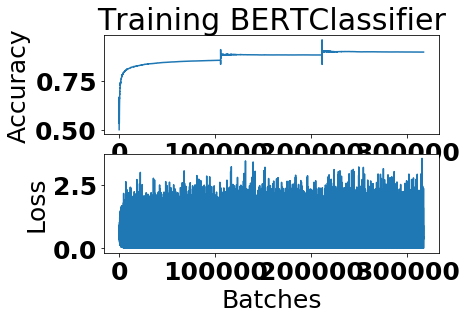

2020-06-15 12:58:32,663 : INFO : wrote 3667 events to disk
  0%|          | 0/11730 [00:00<?, ?it/s]

Time for [train model - 0]: 18:43:07.159812
Start on [evaluate - 0] ...
Start on [prediction] ...


  0%|          | 1/11730 [00:00<31:12,  6.26it/s]2020-06-15 12:58:32,902 : INFO : successfully opened events file: data/yelp_8_pro512BCE/events.out.tfevents.1592218712.cuda2
2020-06-15 12:58:32,902 : INFO : wrote 1 event to disk
2020-06-15 12:58:32,907 : INFO : wrote 1 event to disk
100%|██████████| 11730/11730 [13:58<00:00, 13.98it/s]


Time for [prediction]: 0:13:58.993183
Accuracy in epoch 0: 0.8763925201773332
Confusion Matrix:
[[30781  4443]
 [ 4256 30896]]

CM: [30781  4443  4256 30896] 
[tn, fp, fn, tp]
  accuracy: 0.876
 precision: 0.876
    recall: 0.876
  f1-score: 0.876

Accuracy:  0.876 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     35224
           1       0.87      0.88      0.88     35152

    accuracy                           0.88     70376
   macro avg       0.88      0.88      0.88     70376
weighted avg       0.88      0.88      0.88     70376



2020-06-15 13:12:33,337 : INFO : wrote 6679 events to disk


Time for [evaluate - 0]: 0:14:00.674339


  0%|          | 162/633384 [00:00<06:31, 1617.59it/s]

Start on [train model - 1] ...
Start on [setup training] ...


100%|██████████| 633384/633384 [06:24<00:00, 1647.12it/s]


Time for [setup training]: 0:06:24.736075
Start on [training] ...
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
Time for [training]: 0:00:00.403892


  0%|          | 1/11730 [00:00<27:08,  7.20it/s]2020-06-15 13:18:59,075 : INFO : successfully opened events file: data/yelp_8_pro512BCE/events.out.tfevents.1592219939.cuda2
2020-06-15 13:18:59,075 : INFO : wrote 1 event to disk
2020-06-15 13:18:59,075 : INFO : wrote 1 event to disk


no stats to plot
Time for [train model - 1]: 0:06:25.241723
Start on [evaluate - 1] ...
Start on [prediction] ...


100%|██████████| 11730/11730 [13:56<00:00, 14.02it/s]


Time for [prediction]: 0:13:56.879521
Accuracy in epoch 1: 0.8763925201773332


2020-06-15 13:32:57,464 : INFO : wrote 6625 events to disk


Confusion Matrix:
[[30781  4443]
 [ 4256 30896]]

CM: [30781  4443  4256 30896] 
[tn, fp, fn, tp]
  accuracy: 0.876
 precision: 0.876
    recall: 0.876
  f1-score: 0.876

Accuracy:  0.876 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     35224
           1       0.87      0.88      0.88     35152

    accuracy                           0.88     70376
   macro avg       0.88      0.88      0.88     70376
weighted avg       0.88      0.88      0.88     70376

Time for [evaluate - 1]: 0:13:58.530331


  0%|          | 163/633384 [00:00<06:29, 1625.71it/s]

Start on [train model - 2] ...
Start on [setup training] ...


100%|██████████| 633384/633384 [06:22<00:00, 1655.32it/s]


Time for [setup training]: 0:06:22.822899
Start on [training] ...
loaded checkpoint for epoch 0


  0%|          | 0/11730 [00:00<?, ?it/s]

loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
Time for [training]: 0:00:00.411227
no stats to plot
Time for [train model - 2]: 0:06:23.256282
Start on [evaluate - 2] ...
Start on [prediction] ...


  0%|          | 1/11730 [00:00<41:41,  4.69it/s]2020-06-15 13:39:24,806 : INFO : successfully opened events file: data/yelp_8_pro512BCE/events.out.tfevents.1592221164.cuda2
2020-06-15 13:39:24,807 : INFO : wrote 1 event to disk
2020-06-15 13:39:24,808 : INFO : wrote 1 event to disk
100%|██████████| 11730/11730 [13:56<00:00, 14.03it/s]


Time for [prediction]: 0:13:56.039390
Accuracy in epoch 2: 0.8763925201773332


2020-06-15 13:53:22,289 : INFO : wrote 6611 events to disk


Confusion Matrix:
[[30781  4443]
 [ 4256 30896]]

CM: [30781  4443  4256 30896] 
[tn, fp, fn, tp]
  accuracy: 0.876
 precision: 0.876
    recall: 0.876
  f1-score: 0.876

Accuracy:  0.876 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     35224
           1       0.87      0.88      0.88     35152

    accuracy                           0.88     70376
   macro avg       0.88      0.88      0.88     70376
weighted avg       0.88      0.88      0.88     70376

Time for [evaluate - 2]: 0:13:57.702058
Time for [train model (eval per epoch)]: 19:38:00.183354


In [44]:
with Timer("train model (eval per epoch)"):
    for epoch_id in range(num_epochs):
        with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
            plot_train_stats(stats)

        with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
            print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

            y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
            report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

        model.save_parameters(str(fn_run_path / "bert.model.params"))

In [45]:
plot_train_stats(stats)

no stats to plot


In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [ ]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 7 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

In [ ]:
if False:
    run_name1 = "yelp_1_pro128BCE"
    fn_run_path1 = Path(f"data/{run_name1}")
    epoch_id = num_epochs - 1
    fn_model_state = fn_run_path1 / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)

In [ ]:
if False:
    # for train set
    print("Evaluate trained model for each epoch ...")
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

In [ ]:
if False:
    # for whole dataset
    print("Prepare dataset ...")
    X_dev, y_dev = traindev_df[names_columns_X], traindev_df[names_columns_y]
    _, data_dev = transform_dataset(X_dev, y_dev, transform)

    print("Evaluate trained model for each epoch ...")
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}_all.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} (ALL)", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing (ALL)", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

In [46]:
# merge train df
traindev2_df = X_dev.join(y_dev)

# group train df
grouped_traindev_df = {pairtype: df_grouped for pairtype, df_grouped in traindev2_df.groupby(["type"])}
for pairtype, df_grouped in grouped_traindev_df.items():
    print(pairtype, len(df_grouped))

# split train df
grouped_traindev_df = {
    pairtype: (df_grouped[names_columns_X], df_grouped[names_columns_y])
    for pairtype, df_grouped in grouped_traindev_df.items()
}

bad-bad 17611
bad-good 17631
good-bad 17593
good-good 17541


In [47]:
with Timer("prepare validation data"):
    data_dev_grouped = {
        # data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
        pairtype: transform_dataset(X_dev, y_dev, transform)
        for pairtype, (X_dev, y_dev) in grouped_traindev_df.items()
    }

Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:05.893033


  0%|          | 2/2936 [00:00<04:15, 11.48it/s]

Evaluate trained model on pairtype bad-bad #7...
Start on [prediction] ...


100%|██████████| 2936/2936 [03:29<00:00, 14.04it/s]


Time for [prediction]: 0:03:29.070348
Confusion Matrix:
[[    0     0]
 [ 2719 14892]]

CM: [    0     0  2719 14892] 
[tn, fp, fn, tp]
  accuracy: 0.846
 precision: 0.500
    recall: 0.423
  f1-score: 0.458

Accuracy:  0.846 

Report for [BERTClassifier - yelp_8_pro512BCE - bad-bad]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.85      0.92     17611

    accuracy                           0.85     17611
   macro avg       0.50      0.42      0.46     17611
weighted avg       1.00      0.85      0.92     17611



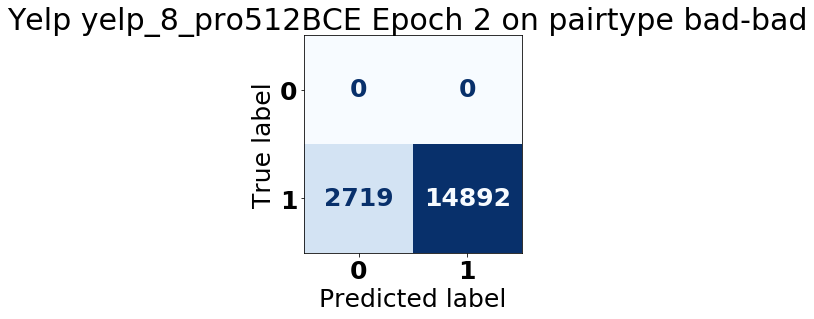

  0%|          | 0/2939 [00:00<?, ?it/s]

Evaluate trained model on pairtype bad-good #8...
Start on [prediction] ...


100%|██████████| 2939/2939 [03:29<00:00, 14.06it/s]


Time for [prediction]: 0:03:29.069839
Confusion Matrix:
[[15533  2098]
 [    0     0]]

CM: [15533  2098     0     0] 
[tn, fp, fn, tp]
  accuracy: 0.881
 precision: 0.500
    recall: 0.441
  f1-score: 0.468

Accuracy:  0.881 

Report for [BERTClassifier - yelp_8_pro512BCE - bad-good]:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     17631
           1       0.00      0.00      0.00         0

    accuracy                           0.88     17631
   macro avg       0.50      0.44      0.47     17631
weighted avg       1.00      0.88      0.94     17631



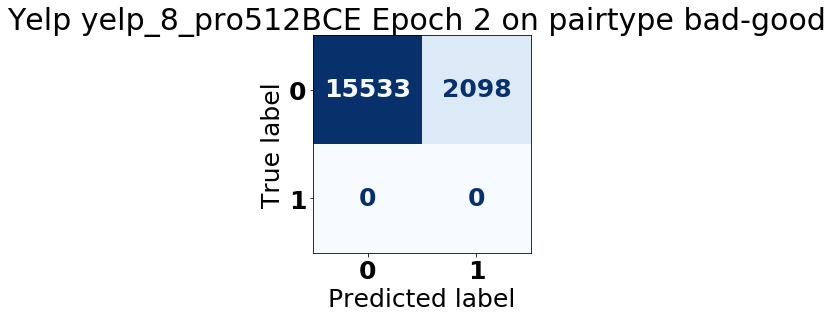

  0%|          | 0/2933 [00:00<?, ?it/s]

Evaluate trained model on pairtype good-bad #8...
Start on [prediction] ...


100%|██████████| 2933/2933 [03:28<00:00, 14.05it/s]


Time for [prediction]: 0:03:28.693344
Confusion Matrix:
[[15248  2345]
 [    0     0]]

CM: [15248  2345     0     0] 
[tn, fp, fn, tp]
  accuracy: 0.867
 precision: 0.500
    recall: 0.433
  f1-score: 0.464

Accuracy:  0.867 

Report for [BERTClassifier - yelp_8_pro512BCE - good-bad]:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     17593
           1       0.00      0.00      0.00         0

    accuracy                           0.87     17593
   macro avg       0.50      0.43      0.46     17593
weighted avg       1.00      0.87      0.93     17593



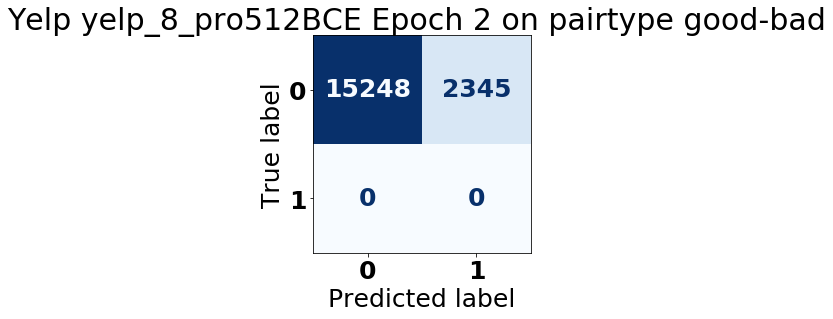

  0%|          | 0/2924 [00:00<?, ?it/s]

Evaluate trained model on pairtype good-good #9...
Start on [prediction] ...


100%|██████████| 2924/2924 [03:26<00:00, 14.18it/s]


Time for [prediction]: 0:03:26.197508
Confusion Matrix:
[[    0     0]
 [ 1537 16004]]

CM: [    0     0  1537 16004] 
[tn, fp, fn, tp]
  accuracy: 0.912
 precision: 0.500
    recall: 0.456
  f1-score: 0.477

Accuracy:  0.912 

Report for [BERTClassifier - yelp_8_pro512BCE - good-good]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.91      0.95     17541

    accuracy                           0.91     17541
   macro avg       0.50      0.46      0.48     17541
weighted avg       1.00      0.91      0.95     17541



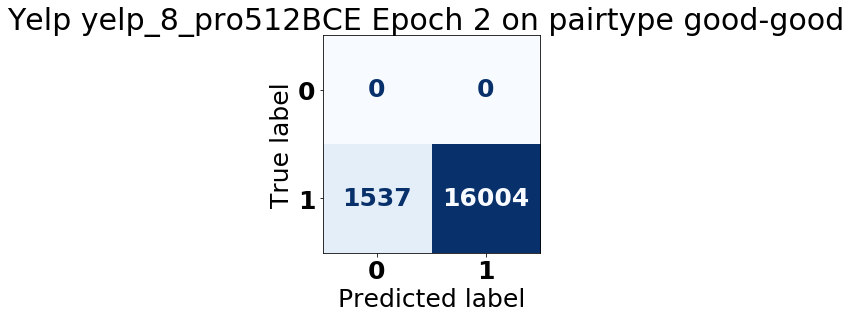

In [48]:
for pairtype, (_, data_dev) in data_dev_grouped.items():
    print(f"Evaluate trained model on pairtype {pairtype} #{len(pairtype)}...")

    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_8_eval_epoch{epoch_id}_{pairtype}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {pairtype}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on pairtype {pairtype}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

pair-type-wise evaluation for yelp_8...

```
          [  tn,   fp,   fn,    tp]   Acc     #num
bad-bad   [    0     0  2719 14892]   0.846   17611
bad-good  [15533  2098     0     0]   0.881   17631
good-bad  [15248  2345     0     0]   0.867   17593
good-good [    0     0  1537 16004]   0.912   17541

all*      [30781  4443  4256 30896]   0.876   70376
```

pair-type-wise evaluation _(on pre-trained yelp_1_* model)_

```
          [  tn,   fp,   fn,    tp]   Acc     #num
bad-bad   [    0     0  4086 13525]   0.768   17611
bad-good  [13637  3994     0     0]   0.773   17631
good-bad  [13742  3851     0     0]   0.781   17593
good-good [    0     0  2200 15341]   0.875   17541

all*      [27379  7845  6286 28866]   0.799   70376
```

---

In [ ]:
# ALL traindev_df
# group train df
grouped_traindev_df = {pairtype: df_grouped for pairtype, df_grouped in traindev_df.groupby(["type"])}
for pairtype, df_grouped in grouped_traindev_df.items():
    print(pairtype, len(df_grouped))

# split train df
grouped_traindev_df = {
    pairtype: (df_grouped[names_columns_X], df_grouped[names_columns_y])
    for pairtype, df_grouped in grouped_traindev_df.items()
}

In [ ]:
with Timer("prepare validation data"):
    data_dev_grouped = {
        # data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
        pairtype: transform_dataset(X_dev, y_dev, transform)[1]
        for pairtype, (X_dev, y_dev) in grouped_traindev_df.items()
    }

In [ ]:
for pairtype, data_dev in data_dev_grouped.items():
    print(f"Evaluate trained model on pairtype {pairtype} #{len(pairtype)}...")

    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}_{pairtype}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {pairtype}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing on pairtype {pairtype}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

pair-type-wise evaluation _(on pre-trained yelp_1_* model)_

```
          [  tn,   fp,   fn,    tp]   Acc     #num
bad-bad   [    0     0  4086 13525]   0.768   17611
bad-good  [13637  3994     0     0]   0.773   17631
good-bad  [13742  3851     0     0]   0.781   17593
good-good [    0     0  2200 15341]   0.875   17541

all*      [27379  7845  6286 28866]   0.799   70376
```

pair-type-wise evaluation _(on pre-trained yelp_1* model)_ using all traindev data (4 per business)

```
          [   tn,    fp,    fn,     tp]   Acc     #num
bad-bad   [     0      0  40575 135365]   0.769   175940
bad-good  [135835  40105      0      0]   0.772   175940
good-bad  [137792  38148      0      0]   0.783   175940
good-good [     0      0  21174 154766]   0.880   175940

all*      [273627  78253  61749 290131]   0.801   703760
```

##### Training with TRAIN set

In [ ]:
fn_run_path

In [ ]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

In [ ]:
plot_train_stats(stats)

##### Results with validation set (DEV set)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

  0%|          | 0/7608 [00:00<?, ?it/s]

Evaluate trained model for each epoch ...
Load data/yelp_8_pro512BCE/bert.model.checkpoint0.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:05<00:00, 13.96it/s]


Time for [prediction]: 0:09:05.121115
Confusion Matrix:
[[19767  3057]
 [ 2692 20132]]

CM: [19767  3057  2692 20132] 
[tn, fp, fn, tp]
  accuracy: 0.874
 precision: 0.874
    recall: 0.874
  f1-score: 0.874

Accuracy:  0.874 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     22824
           1       0.87      0.88      0.88     22824

    accuracy                           0.87     45648
   macro avg       0.87      0.87      0.87     45648
weighted avg       0.87      0.87      0.87     45648



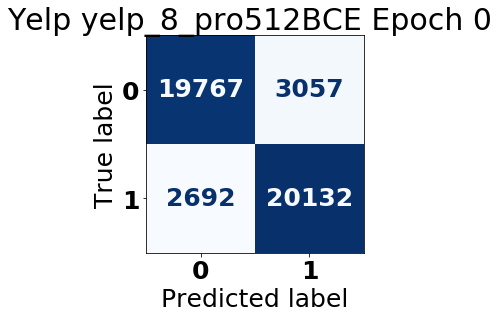

  0%|          | 0/7608 [00:00<?, ?it/s]

Load data/yelp_8_pro512BCE/bert.model.checkpoint1.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:05<00:00, 13.95it/s]


Time for [prediction]: 0:09:05.201917
Confusion Matrix:
[[20246  2578]
 [ 2612 20212]]

CM: [20246  2578  2612 20212] 
[tn, fp, fn, tp]
  accuracy: 0.886
 precision: 0.886
    recall: 0.886
  f1-score: 0.886

Accuracy:  0.886 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22824
           1       0.89      0.89      0.89     22824

    accuracy                           0.89     45648
   macro avg       0.89      0.89      0.89     45648
weighted avg       0.89      0.89      0.89     45648



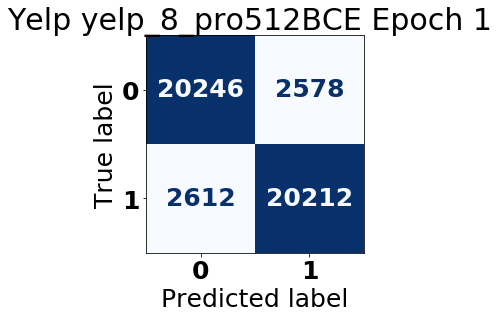

  0%|          | 0/7608 [00:00<?, ?it/s]

Load data/yelp_8_pro512BCE/bert.model.checkpoint2.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:05<00:00, 13.96it/s]


Time for [prediction]: 0:09:05.051128
Confusion Matrix:
[[20245  2579]
 [ 2421 20403]]

CM: [20245  2579  2421 20403] 
[tn, fp, fn, tp]
  accuracy: 0.890
 precision: 0.890
    recall: 0.890
  f1-score: 0.890

Accuracy:  0.89 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22824
           1       0.89      0.89      0.89     22824

    accuracy                           0.89     45648
   macro avg       0.89      0.89      0.89     45648
weighted avg       0.89      0.89      0.89     45648



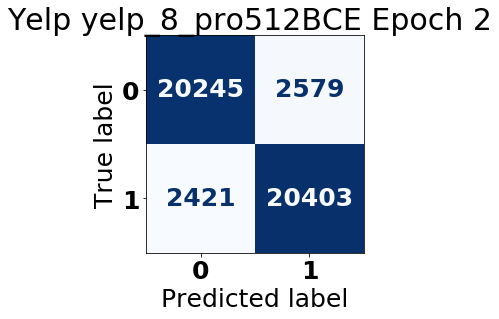

In [58]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

  0%|          | 0/7608 [00:00<?, ?it/s]

Evaluate trained model for each epoch ...
Load data/yelp_8_pro512BCE/bert.model.checkpoint0.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:04<00:00, 13.98it/s]


Time for [prediction]: 0:09:04.319702
Confusion Matrix:
[[19767  3057]
 [ 2692 20132]]

CM: [19767  3057  2692 20132] 
[tn, fp, fn, tp]
  accuracy: 0.874
 precision: 0.874
    recall: 0.874
  f1-score: 0.874

Accuracy:  0.874 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     22824
           1       0.87      0.88      0.88     22824

    accuracy                           0.87     45648
   macro avg       0.87      0.87      0.87     45648
weighted avg       0.87      0.87      0.87     45648



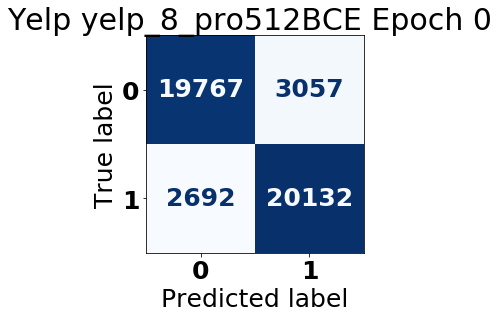

  0%|          | 0/7608 [00:00<?, ?it/s]

Load data/yelp_8_pro512BCE/bert.model.checkpoint1.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:05<00:00, 13.95it/s]


Time for [prediction]: 0:09:05.245615
Confusion Matrix:
[[20246  2578]
 [ 2612 20212]]

CM: [20246  2578  2612 20212] 
[tn, fp, fn, tp]
  accuracy: 0.886
 precision: 0.886
    recall: 0.886
  f1-score: 0.886

Accuracy:  0.886 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22824
           1       0.89      0.89      0.89     22824

    accuracy                           0.89     45648
   macro avg       0.89      0.89      0.89     45648
weighted avg       0.89      0.89      0.89     45648



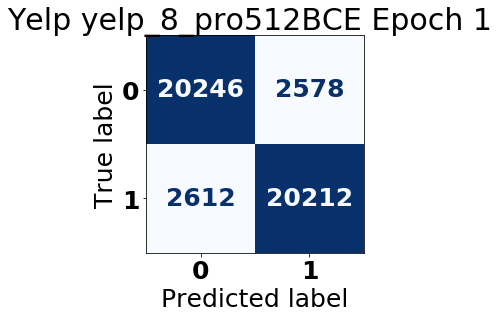

  0%|          | 0/7608 [00:00<?, ?it/s]

Load data/yelp_8_pro512BCE/bert.model.checkpoint2.params ...
Start on [prediction] ...


100%|██████████| 7608/7608 [09:05<00:00, 13.94it/s]


Time for [prediction]: 0:09:05.655029
Confusion Matrix:
[[20245  2579]
 [ 2421 20403]]

CM: [20245  2579  2421 20403] 
[tn, fp, fn, tp]
  accuracy: 0.890
 precision: 0.890
    recall: 0.890
  f1-score: 0.890

Accuracy:  0.89 

Report for [BERTClassifier - yelp_8_pro512BCE]:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22824
           1       0.89      0.89      0.89     22824

    accuracy                           0.89     45648
   macro avg       0.89      0.89      0.89     45648
weighted avg       0.89      0.89      0.89     45648



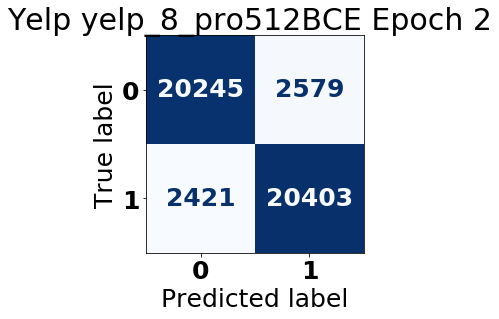

In [60]:
# 2nd attempt to see if it changes anything ...
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

### Load other categories and evaluate

In [50]:
epoch_id = num_epochs - 1
fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_8_pro512BCE/bert.model.checkpoint2.params ...


In [51]:
# lst_root_categories
root_categories = get_root_category_items(map_categories)
root_categories = sorted(root_categories, key=lambda x: x["title"])
root_category_labels = [x["title"] for x in root_categories]

In [ ]:
results_cross_no_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # without overlap
    df_other = filter_root_category_businesses_not_other(root_category_label, category_name, inv_cat_bids, map_categories, map_cat_name2id)
    if df_other.shape[0] == 0: continue

    df_other = filter_min_review_freq(df_other, min_ratings=10)
    df_other = filter_both_good_bad(df_other)
    if df_other.shape[0] == 0: continue
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=4)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_no_overlap[root_category_label] = res_one

Work on Active Life ...


  3%|▎         | 28/1075 [00:00<00:03, 276.55it/s]

#ss (pos) 4300
#ss (neg) 4300


100%|██████████| 1075/1075 [00:03<00:00, 316.43it/s]


#nss 8600
#~ss 17200
review pairs: 17200


  0%|          | 2/2867 [00:00<04:11, 11.40it/s]

Start on [prediction] ...


100%|██████████| 2867/2867 [03:24<00:00, 14.04it/s]


Time for [prediction]: 0:03:24.178770
Confusion Matrix:
[[7465 1135]
 [1081 7519]]

CM: [7465 1135 1081 7519] 
[tn, fp, fn, tp]
  accuracy: 0.871
 precision: 0.871
    recall: 0.871
  f1-score: 0.871

Accuracy:  0.871 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Active Life]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      8600
           1       0.87      0.87      0.87      8600

    accuracy                           0.87     17200
   macro avg       0.87      0.87      0.87     17200
weighted avg       0.87      0.87      0.87     17200



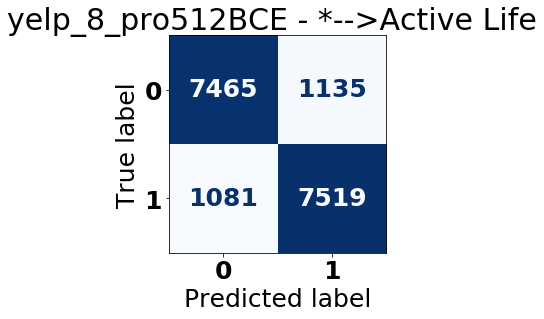

Work on Arts & Entertainment ...


  0%|          | 6/1540 [00:00<00:25, 59.70it/s]

#ss (pos) 6160
#ss (neg) 6160


100%|██████████| 1540/1540 [00:04<00:00, 313.09it/s]


#nss 12320
#~ss 24640
review pairs: 24640


  0%|          | 2/4107 [00:00<05:29, 12.45it/s]

Start on [prediction] ...


100%|██████████| 4107/4107 [04:54<00:00, 13.94it/s]


Time for [prediction]: 0:04:54.661738
Confusion Matrix:
[[10255  2065]
 [ 1921 10399]]

CM: [10255  2065  1921 10399] 
[tn, fp, fn, tp]
  accuracy: 0.838
 precision: 0.838
    recall: 0.838
  f1-score: 0.838

Accuracy:  0.838 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     12320
           1       0.83      0.84      0.84     12320

    accuracy                           0.84     24640
   macro avg       0.84      0.84      0.84     24640
weighted avg       0.84      0.84      0.84     24640



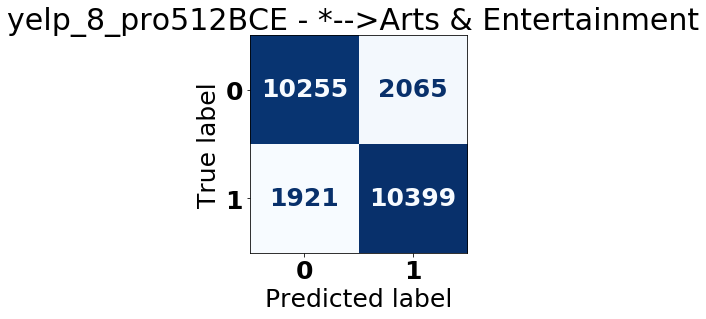

Work on Automotive ...


  2%|▏         | 28/1438 [00:00<00:05, 273.38it/s]

#ss (pos) 5752
#ss (neg) 5752


100%|██████████| 1438/1438 [00:04<00:00, 316.95it/s]


#nss 11504
#~ss 23008
review pairs: 23008


  0%|          | 2/3835 [00:00<05:12, 12.26it/s]

Start on [prediction] ...


100%|██████████| 3835/3835 [04:34<00:00, 13.97it/s]


Time for [prediction]: 0:04:34.516383
Confusion Matrix:
[[10822   682]
 [  700 10804]]

CM: [10822   682   700 10804] 
[tn, fp, fn, tp]
  accuracy: 0.940
 precision: 0.940
    recall: 0.940
  f1-score: 0.940

Accuracy:  0.94 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Automotive]:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11504
           1       0.94      0.94      0.94     11504

    accuracy                           0.94     23008
   macro avg       0.94      0.94      0.94     23008
weighted avg       0.94      0.94      0.94     23008



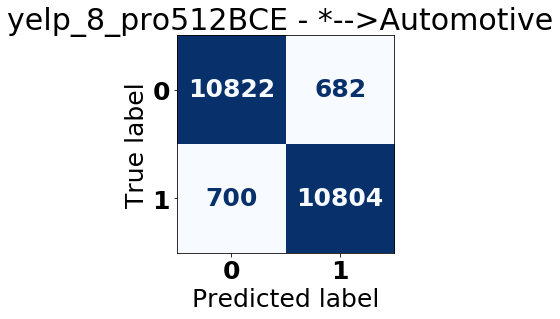

Work on Beauty & Spas ...


  1%|          | 18/2520 [00:00<00:14, 176.13it/s]

#ss (pos) 10080
#ss (neg) 10080


100%|██████████| 2520/2520 [00:08<00:00, 310.04it/s]


#nss 20160
#~ss 40320
review pairs: 40320


  0%|          | 2/6720 [00:00<10:04, 11.12it/s]

Start on [prediction] ...


100%|██████████| 6720/6720 [07:59<00:00, 14.02it/s]


Time for [prediction]: 0:07:59.300662
Confusion Matrix:
[[18985  1175]
 [ 1246 18914]]

CM: [18985  1175  1246 18914] 
[tn, fp, fn, tp]
  accuracy: 0.940
 precision: 0.940
    recall: 0.940
  f1-score: 0.940

Accuracy:  0.94 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20160
           1       0.94      0.94      0.94     20160

    accuracy                           0.94     40320
   macro avg       0.94      0.94      0.94     40320
weighted avg       0.94      0.94      0.94     40320



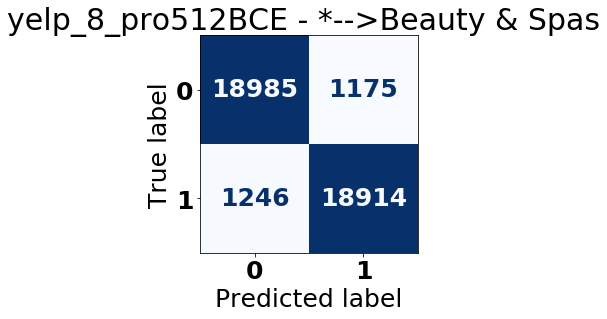

Work on Bicycles ...
Work on Education ...


 19%|█▉        | 32/168 [00:00<00:00, 313.31it/s]

#ss (pos) 672
#ss (neg) 672


100%|██████████| 168/168 [00:00<00:00, 318.46it/s]


#nss 1344
#~ss 2688
review pairs: 2688


  0%|          | 2/448 [00:00<00:36, 12.32it/s]

Start on [prediction] ...


100%|██████████| 448/448 [00:32<00:00, 13.83it/s]


Time for [prediction]: 0:00:32.385327
Confusion Matrix:
[[1189  155]
 [ 153 1191]]

CM: [1189  155  153 1191] 
[tn, fp, fn, tp]
  accuracy: 0.885
 precision: 0.885
    recall: 0.885
  f1-score: 0.885

Accuracy:  0.885 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Education]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1344
           1       0.88      0.89      0.89      1344

    accuracy                           0.89      2688
   macro avg       0.89      0.89      0.89      2688
weighted avg       0.89      0.89      0.89      2688



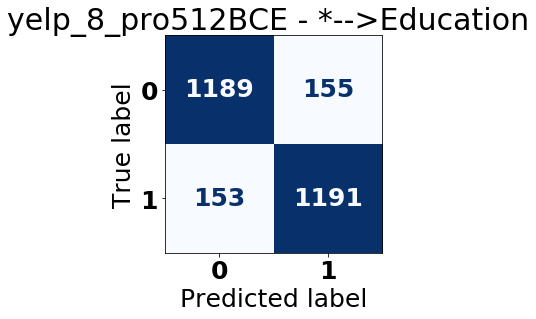

Work on Event Planning & Services ...


  0%|          | 0/2409 [00:00<?, ?it/s]

#ss (pos) 9636
#ss (neg) 9636


100%|██████████| 2409/2409 [00:07<00:00, 318.91it/s]


#nss 19272
#~ss 38544
review pairs: 38544


  0%|          | 2/6424 [00:00<09:30, 11.25it/s]

Start on [prediction] ...


100%|██████████| 6424/6424 [07:41<00:00, 13.92it/s]


Time for [prediction]: 0:07:41.372078
Confusion Matrix:
[[16790  2482]
 [ 2412 16860]]

CM: [16790  2482  2412 16860] 
[tn, fp, fn, tp]
  accuracy: 0.873
 precision: 0.873
    recall: 0.873
  f1-score: 0.873

Accuracy:  0.873 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     19272
           1       0.87      0.87      0.87     19272

    accuracy                           0.87     38544
   macro avg       0.87      0.87      0.87     38544
weighted avg       0.87      0.87      0.87     38544



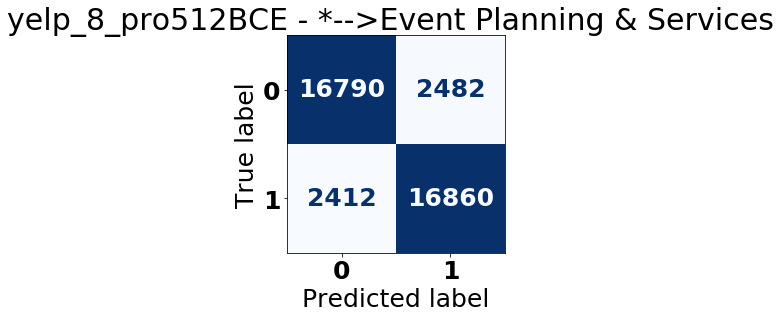

  0%|          | 0/82 [00:00<?, ?it/s]

Work on Financial Services ...


 41%|████▏     | 34/82 [00:00<00:00, 332.73it/s]

#ss (pos) 328
#ss (neg) 328


  0%|          | 0/219 [00:00<?, ?it/s]

#nss 656
#~ss 1312
review pairs: 1312
Start on [prediction] ...


100%|██████████| 219/219 [00:15<00:00, 14.01it/s]


Time for [prediction]: 0:00:15.633048
Confusion Matrix:
[[626  30]
 [ 35 621]]

CM: [626  30  35 621] 
[tn, fp, fn, tp]
  accuracy: 0.950
 precision: 0.950
    recall: 0.950
  f1-score: 0.950

Accuracy:  0.95 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Financial Services]:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       656
           1       0.95      0.95      0.95       656

    accuracy                           0.95      1312
   macro avg       0.95      0.95      0.95      1312
weighted avg       0.95      0.95      0.95      1312



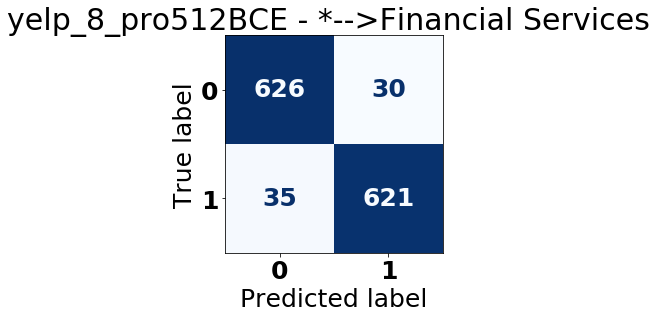

Work on Food ...


100%|██████████| 8171/8171 [00:26<00:00, 303.79it/s]


#ss (pos) 32684
#ss (neg) 32684


100%|██████████| 8171/8171 [00:26<00:00, 306.15it/s]


#nss 65368
#~ss 130736
review pairs: 130736


  0%|          | 2/21790 [00:00<32:04, 11.32it/s]

Start on [prediction] ...


100%|██████████| 21790/21790 [25:51<00:00, 14.05it/s]


Time for [prediction]: 0:25:51.014166
Confusion Matrix:
[[56635  8733]
 [ 8319 57049]]

CM: [56635  8733  8319 57049] 
[tn, fp, fn, tp]
  accuracy: 0.870
 precision: 0.870
    recall: 0.870
  f1-score: 0.870

Accuracy:  0.87 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Food]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     65368
           1       0.87      0.87      0.87     65368

    accuracy                           0.87    130736
   macro avg       0.87      0.87      0.87    130736
weighted avg       0.87      0.87      0.87    130736



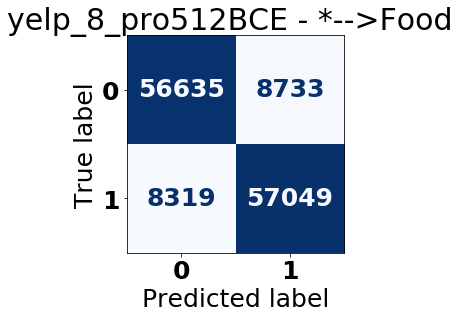

Work on Health & Medical ...


  2%|▏         | 28/1368 [00:00<00:04, 278.50it/s]

#ss (pos) 5472
#ss (neg) 5472


100%|██████████| 1368/1368 [00:04<00:00, 287.22it/s]


#nss 10944
#~ss 21888
review pairs: 21888


  0%|          | 2/3648 [00:00<05:16, 11.51it/s]

Start on [prediction] ...


100%|██████████| 3648/3648 [04:22<00:00, 13.90it/s]


Time for [prediction]: 0:04:22.529655
Confusion Matrix:
[[10361   583]
 [  664 10280]]

CM: [10361   583   664 10280] 
[tn, fp, fn, tp]
  accuracy: 0.943
 precision: 0.943
    recall: 0.943
  f1-score: 0.943

Accuracy:  0.943 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10944
           1       0.95      0.94      0.94     10944

    accuracy                           0.94     21888
   macro avg       0.94      0.94      0.94     21888
weighted avg       0.94      0.94      0.94     21888



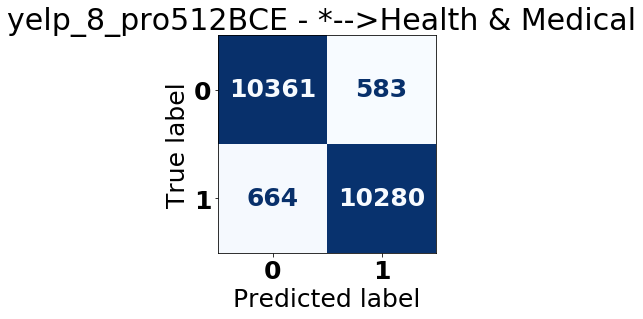

Work on Home Services ...


  2%|▏         | 30/1212 [00:00<00:04, 292.74it/s]

#ss (pos) 4848
#ss (neg) 4848


100%|██████████| 1212/1212 [00:03<00:00, 327.12it/s]


#nss 9696
#~ss 19392
review pairs: 19392


  0%|          | 2/3232 [00:00<04:22, 12.33it/s]

Start on [prediction] ...


100%|██████████| 3232/3232 [03:53<00:00, 13.84it/s]


Time for [prediction]: 0:03:53.498439
Confusion Matrix:
[[9160  536]
 [ 541 9155]]

CM: [9160  536  541 9155] 
[tn, fp, fn, tp]
  accuracy: 0.944
 precision: 0.944
    recall: 0.944
  f1-score: 0.944

Accuracy:  0.944 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Home Services]:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9696
           1       0.94      0.94      0.94      9696

    accuracy                           0.94     19392
   macro avg       0.94      0.94      0.94     19392
weighted avg       0.94      0.94      0.94     19392



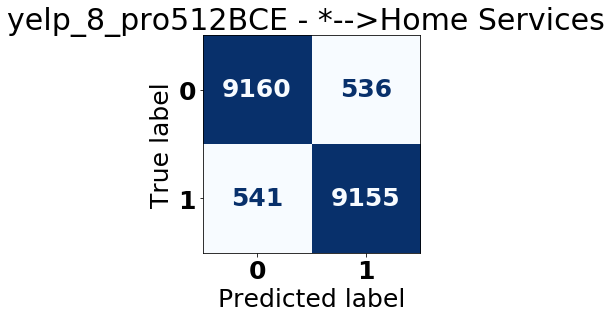

Work on Hotels & Travel ...


  1%|▏         | 19/1357 [00:00<00:07, 188.88it/s]

#ss (pos) 5428
#ss (neg) 5428


100%|██████████| 1357/1357 [00:04<00:00, 322.38it/s]


#nss 10856
#~ss 21712
review pairs: 21712


  0%|          | 2/3619 [00:00<05:02, 11.95it/s]

Start on [prediction] ...


100%|██████████| 3619/3619 [04:21<00:00, 13.84it/s]


Time for [prediction]: 0:04:21.562731
Confusion Matrix:
[[9466 1390]
 [1397 9459]]

CM: [9466 1390 1397 9459] 
[tn, fp, fn, tp]
  accuracy: 0.872
 precision: 0.872
    recall: 0.872
  f1-score: 0.872

Accuracy:  0.872 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     10856
           1       0.87      0.87      0.87     10856

    accuracy                           0.87     21712
   macro avg       0.87      0.87      0.87     21712
weighted avg       0.87      0.87      0.87     21712



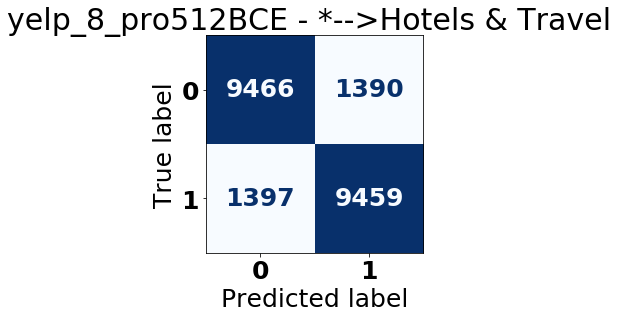

Work on Local Flavor ...


  9%|▉         | 30/341 [00:00<00:01, 294.01it/s]

#ss (pos) 1364
#ss (neg) 1364


100%|██████████| 341/341 [00:01<00:00, 311.63it/s]


#nss 2728
#~ss 5456
review pairs: 5456


  0%|          | 2/910 [00:00<01:15, 12.10it/s]

Start on [prediction] ...


100%|██████████| 910/910 [01:05<00:00, 13.97it/s]


Time for [prediction]: 0:01:05.148876
Confusion Matrix:
[[2282  446]
 [ 405 2323]]

CM: [2282  446  405 2323] 
[tn, fp, fn, tp]
  accuracy: 0.844
 precision: 0.844
    recall: 0.844
  f1-score: 0.844

Accuracy:  0.844 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2728
           1       0.84      0.85      0.85      2728

    accuracy                           0.84      5456
   macro avg       0.84      0.84      0.84      5456
weighted avg       0.84      0.84      0.84      5456



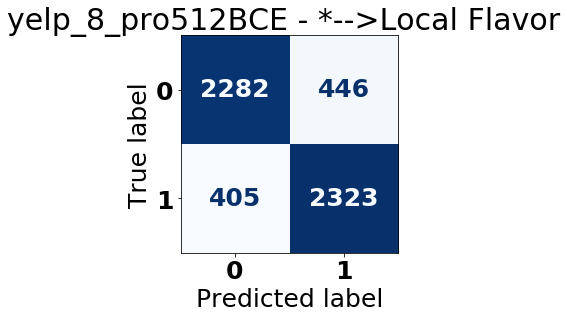

Work on Local Services ...


  3%|▎         | 29/871 [00:00<00:02, 289.79it/s]

#ss (pos) 3484
#ss (neg) 3484


100%|██████████| 871/871 [00:02<00:00, 320.36it/s]


#nss 6968
#~ss 13936
review pairs: 13936


  0%|          | 2/2323 [00:00<03:07, 12.35it/s]

Start on [prediction] ...


100%|██████████| 2323/2323 [02:46<00:00, 13.98it/s]


Time for [prediction]: 0:02:46.152522
Confusion Matrix:
[[6544  424]
 [ 471 6497]]

CM: [6544  424  471 6497] 
[tn, fp, fn, tp]
  accuracy: 0.936
 precision: 0.936
    recall: 0.936
  f1-score: 0.936

Accuracy:  0.936 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Local Services]:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6968
           1       0.94      0.93      0.94      6968

    accuracy                           0.94     13936
   macro avg       0.94      0.94      0.94     13936
weighted avg       0.94      0.94      0.94     13936



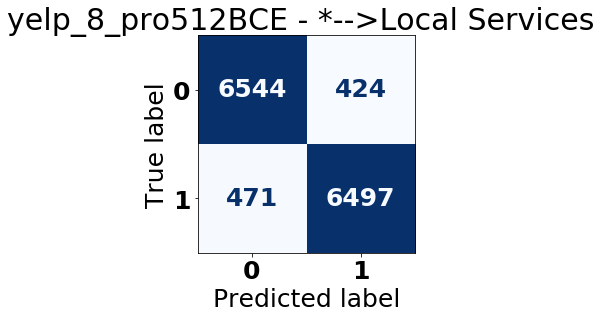

Work on Mass Media ...


  0%|          | 0/30 [00:00<?, ?it/s]

#ss (pos) 44
#ss (neg) 44
#nss 88
#~ss 176
review pairs: 176
Start on [prediction] ...


100%|██████████| 30/30 [00:02<00:00, 14.20it/s]

Time for [prediction]: 0:00:02.114239
Confusion Matrix:
[[78 10]
 [ 8 80]]

CM: [78 10  8 80] 
[tn, fp, fn, tp]
  accuracy: 0.898
 precision: 0.898
    recall: 0.898
  f1-score: 0.898

Accuracy:  0.898 

Report for [BERTClassifier - yelp_8_pro512BCE - *-->Mass Media]:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        88
           1       0.89      0.91      0.90        88

    accuracy                           0.90       176
   macro avg       0.90      0.90      0.90       176
weighted avg       0.90      0.90      0.90       176



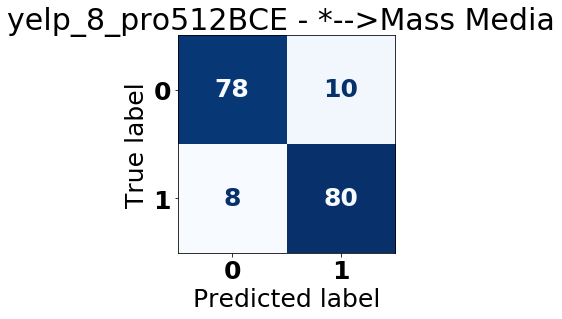

Work on Nightlife ...


100%|██████████| 6126/6126 [00:20<00:00, 305.82it/s]


#ss (pos) 24504
#ss (neg) 24504


100%|██████████| 6126/6126 [00:20<00:00, 305.99it/s]


#nss 49008
#~ss 98016
review pairs: 98016


  0%|          | 2/16336 [00:00<23:25, 11.62it/s]

Start on [prediction] ...


 43%|████▎     | 6990/16336 [08:19<11:04, 14.05it/s]

In [ ]:
results_cross_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # with overlap
    df_other = load_cached_root_category_businesses_df(root_category_label, map_categories)
    if df_other.shape[0] == 0: continue

    df_other = filter_min_review_freq(df_other, min_ratings=10)
    df_other = filter_both_good_bad(df_other)
    if df_other.shape[0] == 0: continue
    # TODO: maybe reset randomness here, so previous calls to random don't influence it?
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=4)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_overlap[root_category_label] = res_one

In [ ]:
results_cross_no_overlap

In [59]:
results_cross_overlap

{'Active Life': (17200,
  17200,
  0.8711774250050205,
  0.8711627906976744,
  0.871161520778105,
  0.8711627906976744,
  array([[7465, 1135],
         [1081, 7519]])),
 'Arts & Entertainment': (24640,
  24640,
  0.8382767337079278,
  0.8382305194805195,
  0.8382249941914865,
  0.8382305194805195,
  array([[10255,  2065],
         [ 1921, 10399]])),
 'Automotive': (23008,
  23008,
  0.9399350130720711,
  0.9399339360222532,
  0.9399338992587648,
  0.9399339360222532,
  array([[10822,   682],
         [  700, 10804]])),
 'Beauty & Spas': (40320,
  40320,
  0.9399608140886396,
  0.9399553571428572,
  0.9399551709550388,
  0.9399553571428572,
  array([[18985,  1175],
         [ 1246, 18914]])),
 'Education': (2688,
  2688,
  0.8854175201457982,
  0.8854166666666667,
  0.8854166032325123,
  0.8854166666666666,
  array([[1189,  155],
         [ 153, 1191]])),
 'Event Planning & Services': (38544,
  38544,
  0.8730331488946446,
  0.8730282274802823,
  0.873027808695271,
  0.8730282274802823,

In [ ]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_no_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

In [57]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 87.12%  87.12%  87.12%  87.12%  -- [7465, 1135, 1081, 7519]
Arts & Entertainment          : 83.83%  83.82%  83.82%  83.82%  -- [10255, 2065, 1921, 10399]
Automotive                    : 93.99%  93.99%  93.99%  93.99%  -- [10822, 682, 700, 10804]
Beauty & Spas                 : 94.00%  94.00%  94.00%  94.00%  -- [18985, 1175, 1246, 18914]
Education                     : 88.54%  88.54%  88.54%  88.54%  -- [1189, 155, 153, 1191]
Event Planning & Services     : 87.30%  87.30%  87.30%  87.30%  -- [16790, 2482, 2412, 16860]
Financial Services            : 95.05%  95.05%  95.05%  95.05%  -- [626, 30, 35, 621]
Food                          : 86.96%  86.96%  86.96%  86.96%  -- [56635, 8733, 8319, 57049]
Health & Medical              : 94.31%  94.30%  94.30%  94.30%  -- [10361, 583, 664, 10280]
Home Services                 : 94.45%  94.45%  94.45%  94.45%  -- [9160, 536,

In [ ]:
fn_results = fn_run_path / "results_cross_dicts.p"

with open(fn_results, "wb") as fp:
    pickle.dump((category_name, "overlap", results_cross_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)
    # below may not have made sense (because we trained on all data, so there should be overlap?)
    #                                         results_cross_no_overlap
    pickle.dump((category_name, "no overlap", None), fp, protocol=pickle.HIGHEST_PROTOCOL)